# Expanding CUDA-Q's ecosystem through Qibolab Emulator (for Anyon QPUs)

The Qibolab emulator attempts to serve as a digital twin of a specific QPU by performing pulse-level simulations based on an underlying model that captures the essential physics of the QPU including its coherent and incoherent noises. In this tutorial, we showcase representative emulators based on one of Anyon's latest QPU designs using parametric two-qubit gates.

## Setting up and initializing the emulator backends

The emulator is publicly available as part of the qibolab repository https://github.com/qiboteam/qibolab.git under the `anyon_emulator` branch. The environment has already been set up in the login node for this tutorial.

The emulator is a qibolab backend and needs to be instantiated by first adding the path to the parent folder of the emulator platform to the `QIBOLAB_PLATFORMS` environment variable and then using `qibolab.create_platform`. In this tutorial, we will showcase 3 different emulators `anyon_2q_CZ`, `anyon_2q_iSWAP` and `anyon_4q_CZ` that can be found in the same folder as this notebook:

In [1]:
# add directory of emulator platforms to QIBOLAB_PLATFORMS environment variable
import pathlib, os
import numpy as np
emulator_path = pathlib.Path(os.path.abspath(''))
os.environ["QIBOLAB_PLATFORMS"] = emulator_path.as_posix() 

# create emulator platforms
from qibolab import create_platform
platform_2q_CZ = create_platform("anyon_2q_CZ")
platform_2q_iSWAP = create_platform("anyon_2q_iSWAP")
platform_4q_CZ = create_platform("anyon_4q_CZ")

# create corresponding backends
from qibolab.backends import QibolabBackend
backend_2q_CZ = QibolabBackend(platform=platform_2q_CZ)
backend_2q_iSWAP = QibolabBackend(platform=platform_2q_iSWAP)
backend_4q_CZ = QibolabBackend(platform=platform_4q_CZ)

[Qibo 0.2.16|INFO|2025-03-08 19:58:07]: Loading platform anyon_2q_CZ_emulator
INFO:qibo.config:Loading platform anyon_2q_CZ_emulator
[Qibo 0.2.16|INFO|2025-03-08 19:58:07]: Loading platform anyon_2q_iSWAP_emulator
INFO:qibo.config:Loading platform anyon_2q_iSWAP_emulator
[Qibo 0.2.16|INFO|2025-03-08 19:58:07]: Loading platform anyon_4q_CZ_emulator
INFO:qibo.config:Loading platform anyon_4q_CZ_emulator


We can visualize the quantum dynamics model that the emulator is based on. The following model is customized according to the anyon QPU devices that we are showcasing in this tutorial.

In [2]:
from qibolab_visualization.emulator import print_hamiltonian

print_hamiltonian(platform_2q_CZ.instruments['pulse_simulator'].simulation_engine.model_config)

Dictionary


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



---------------------
One-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
One-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Dissipative terms:
---------------------
>> t1 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

>> t2 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------


## Running CUDA-Q circuits on the Qibolab emulator

### Example 1: Bell Circuit

In the first example, we construct a bell circuit in cudaq simulator and compute its final state (density matrix):

In [3]:
import cudaq
import numpy as np

# Construct bell circuit
bell_pair = cudaq.make_kernel()
qubits = bell_pair.qalloc(2)
bell_pair.h(qubits[0])         
bell_pair.cx(qubits[0], qubits[1]) 

# Set computation backend
cudaq.set_target("qpp-cpu")
 
# Draw the quantum circuit.
print(cudaq.draw(bell_pair))

# Compute the statevector and corresponding density matrix
statevector = np.array(cudaq.get_state(bell_pair)) 
density_matrix = np.outer(statevector, statevector.conjugate())

# print the density matrix to desired precision
precision = 3
print(np.round(density_matrix, precision))

/apps/conda/jykhoo/envs/cudaq_qibolab_emu_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ╭───╮     
q0 : ┤ h ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]


We load the emulator backend/platform of interest to execute the circuit in terms of the QPU's native pulse sequence. The first step in this is to get the pulse sequence:

[Qibo 0.2.16|INFO|2025-03-08 12:19:48]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


PulseSequence
DrivePulse(0, 40, 0.086614, 5_675_200_000, 4.712389, Rectangular(), drive-1, 1)
DrivePulse(40, 40, 0.153543, 5_528_450_000, 4.712389, Rectangular(), drive-0, 0)
DrivePulse(80, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(176, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(272, 40, 0.153543, 5_528_450_000, 7.853982, Rectangular(), drive-0, 0)
ReadoutPulse(312, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
ReadoutPulse(312, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-1, 1)


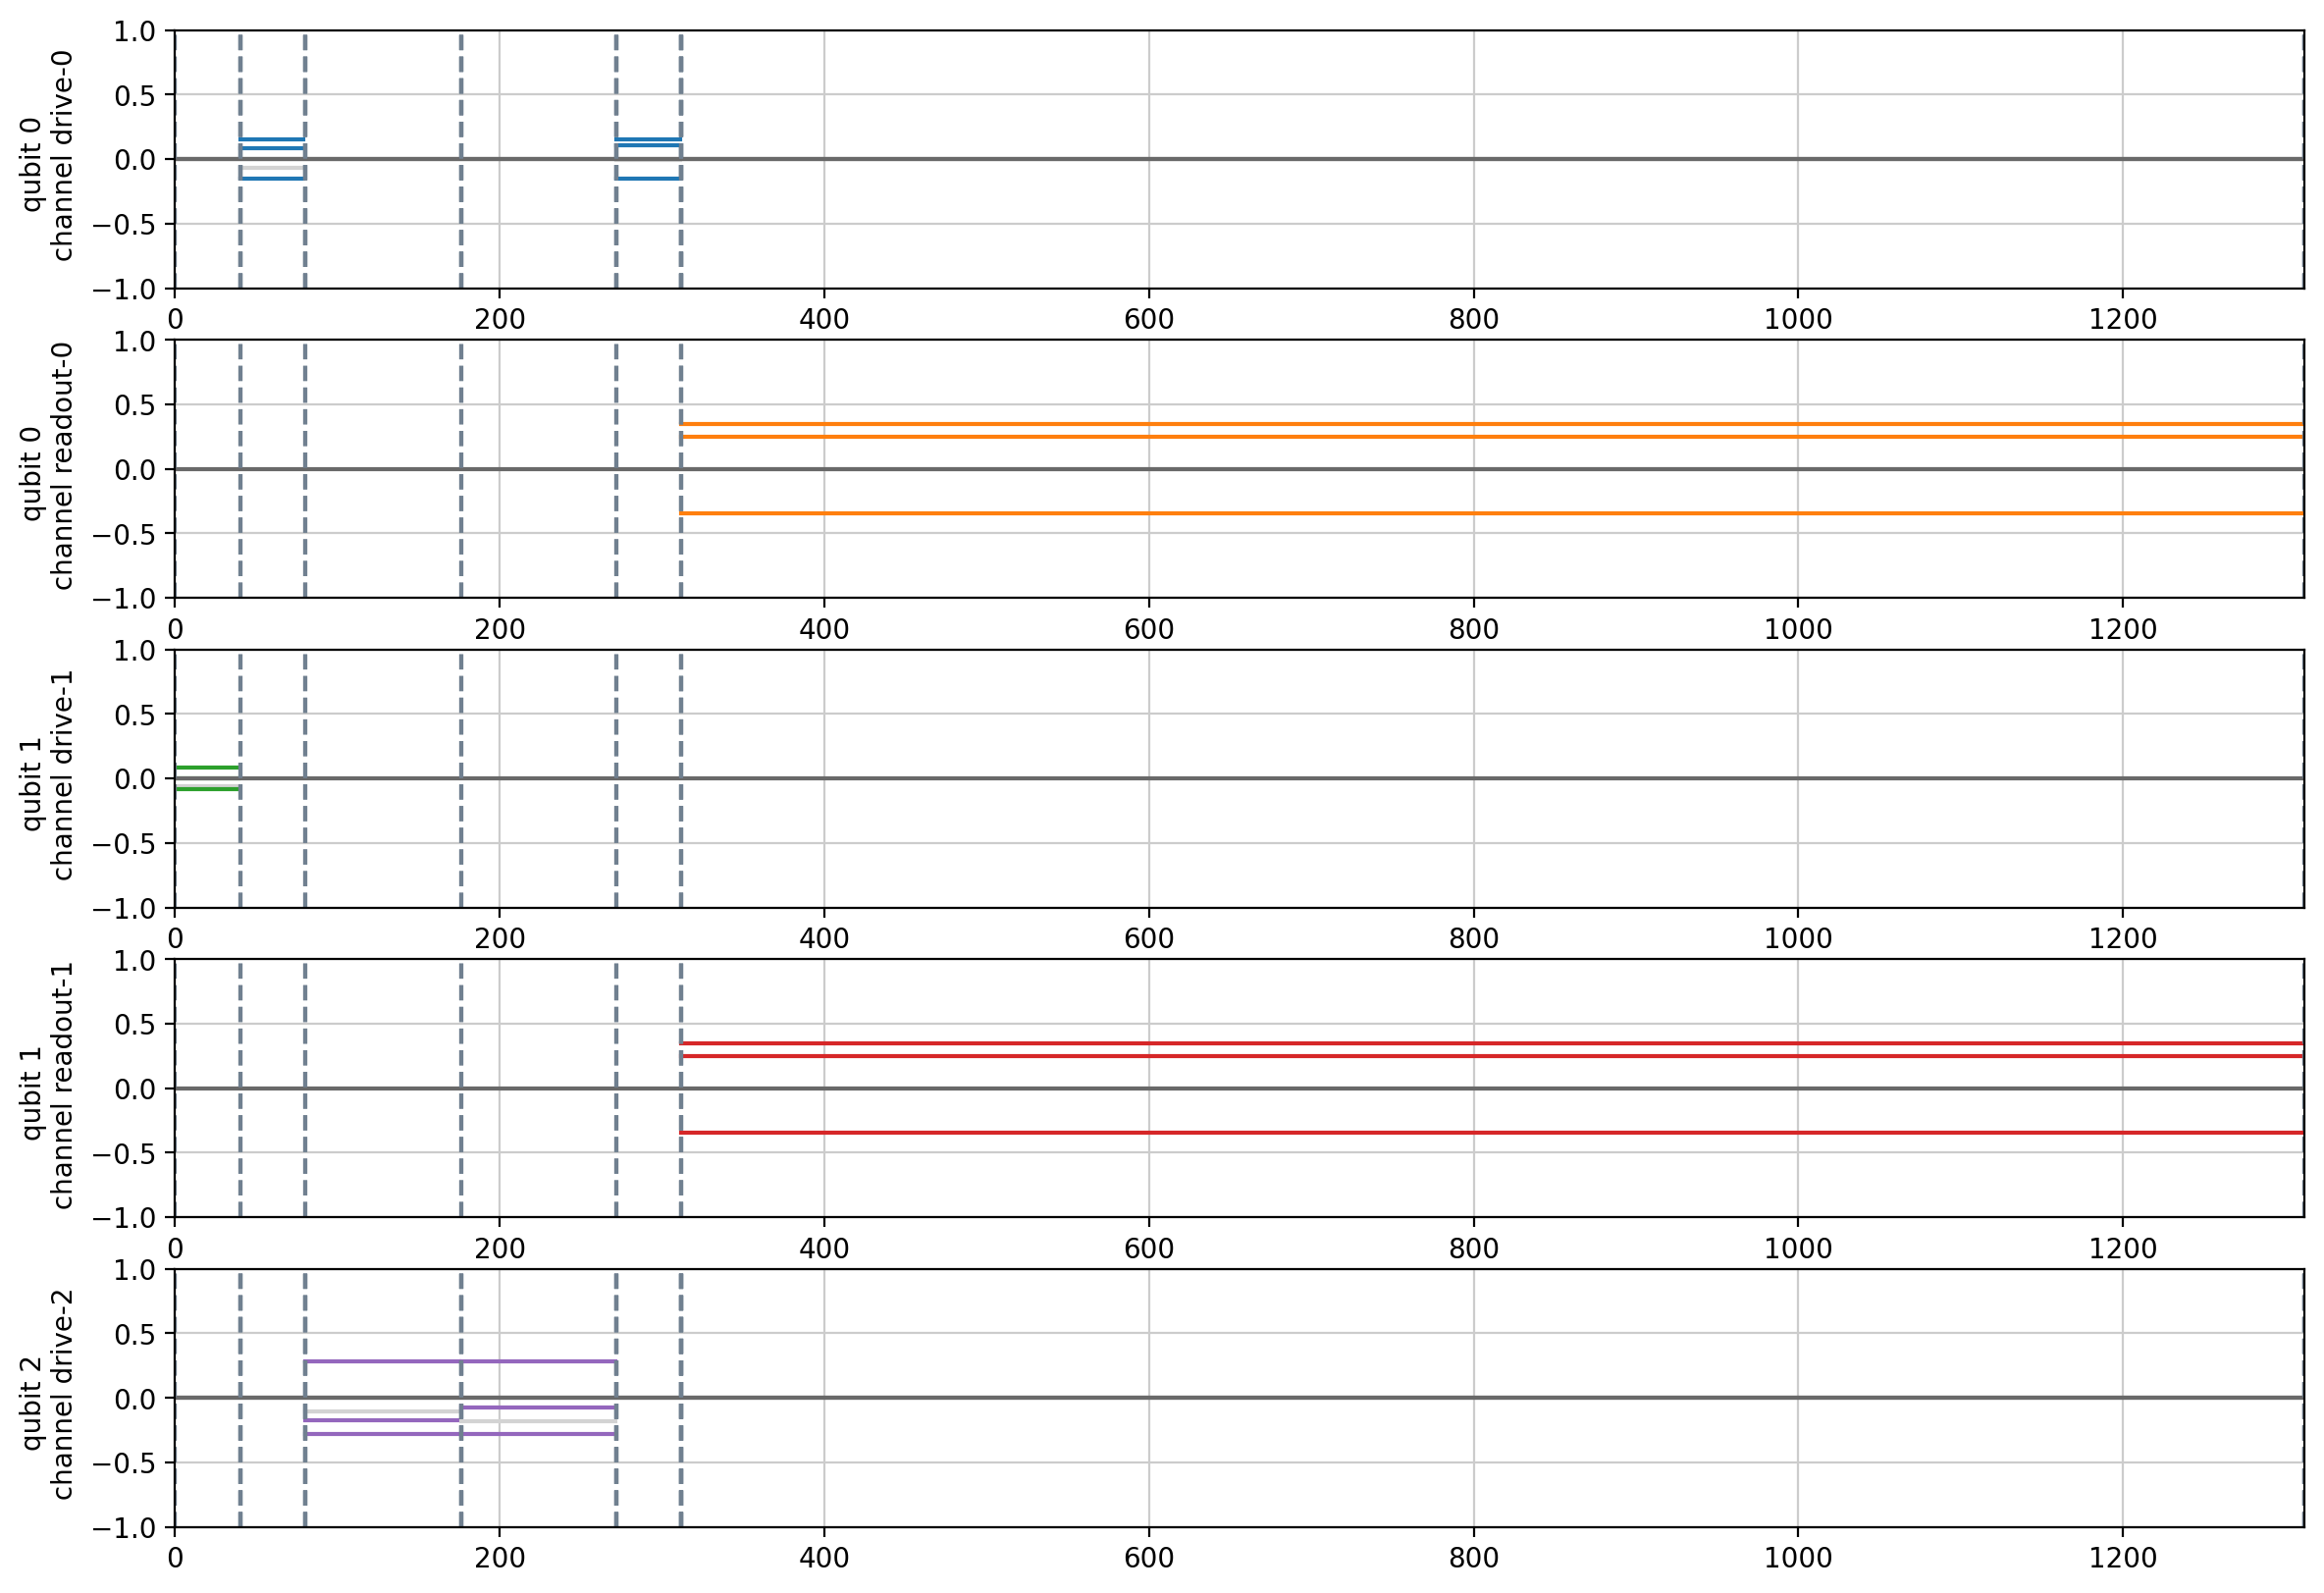

In [4]:
from qibolab.instruments.emulator.transpile_utils import get_pulse_sequence

# set the emulator platform and backend for this example
platform = platform_2q_CZ
backend = backend_2q_CZ

# get pulse sequence corresponding to the gates after transpiling to native pulses of the hardware.
# add_measure_all=True adds readout pulses (corresponding to measurements) to all qubits.
pulse_sequence = get_pulse_sequence(bell_pair, backend, add_measure_all=True)

# show the pulse sequence organized into their various channels
print(pulse_sequence)
pulse_sequence.plot()

To execute the pulse sequence, we first need to specify some settings. The first is the number of shots (nshots). Two other settings pertain to the simulation:
1) output_state_history=True stores all the states generated at each time step in the simulation.
2) simulate_dissipation=True turns on the dissipation introduced by T1 and T2 times in the simulation. This will result in substantially longer simulation times compared to when it is False, since the Lindblad master equation is used to evolve the density matrix of the system.

In [5]:
from qibolab.execution_parameters import ExecutionParameters

# settings
nshots = 2975
options = ExecutionParameters(nshots=nshots)
platform.instruments['pulse_simulator'].output_state_history = True
platform.instruments['pulse_simulator'].simulate_dissipation = False

# execute pulse sequence on emulator
results = platform.execute_pulse_sequence(pulse_sequence, options=options)

[Qibo 0.2.16|INFO|2025-03-08 19:58:15]: Minimal execution time (sequence): 0.8964032000000001
INFO:qibo.config:Minimal execution time (sequence): 0.8964032000000001


PulseSequence
DrivePulse(0, 40, 0.086614, 5_675_200_000, 4.712389, Rectangular(), drive-1, 1)
DrivePulse(40, 40, 0.153543, 5_528_450_000, 4.712389, Rectangular(), drive-0, 0)
DrivePulse(80, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(176, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(272, 40, 0.153543, 5_528_450_000, 7.853982, Rectangular(), drive-0, 0)
ReadoutPulse(312, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
ReadoutPulse(312, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-1, 1)
 [**        9%           ] Elapsed 2.18s / Remaining 00:00:00:22

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [******   24%           ] Elapsed 5.70s / Remaining 00:00:00:18

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********38%           ] Elapsed 9.01s / Remaining 00:00:00:14

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********53%           ] Elapsed 12.45s / Remaining 00:00:00:11

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********67%***        ] Elapsed 15.70s / Remaining 00:00:00:07

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********83%*******    ] Elapsed 19.17s / Remaining 00:00:00:03

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********99%***********] Elapsed 22.89s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



We can visualize the evolution of the system's state by computing its overlap with all its basis states at each time step. In this case, the model simulates each qubit as a three level system, where $\ket{0}$ and $\ket{1}$ are the computational states of each qubit.

Overlap of final state with basis states:
|00> 0.5087732377295492
|10> 0.00013597842611453727
|20> 0.00010314450772368829
|01> 4.920855838574805e-05
|11> 0.4902070682544134
|21> 0.00041650997659210956
|02> 0.0002796438969568012
|12> 2.4700728224309058e-05
|22> 5.8135799080345076e-08


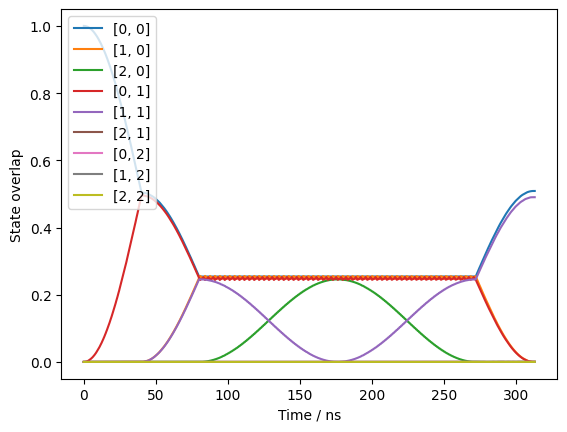

In [6]:
# visualize evolution of system's state during pulse sequence
from qibolab_visualization.emulator import plot_overlaps

simulation_results = results['simulation']
simulated_states = simulation_results['output_states']
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

simulation_engine = platform.instruments['pulse_simulator'].simulation_engine
overlaps = simulation_engine.compute_overlaps(simulated_states)

from qibolab_visualization.emulator import plot_overlaps
fig = plot_overlaps(overlaps,sim_time_list,time_label='Time / ns');

The final density matrix of the system can be projected back to its two-level subspace for ease of visualization:

In [7]:
from qibolab.instruments.emulator.engines.qutip_engine import proj_to_2levelHS

# show density matrix of final state
final_state = simulated_states[-1]
proj_dm = proj_to_2levelHS(final_state)
print(np.round(proj_dm, precision))

[[ 0.509+0.j    -0.001+0.008j  0.002-0.005j -0.443-0.231j]
 [-0.001-0.008j  0.   +0.j    -0.   -0.j    -0.003+0.008j]
 [ 0.002+0.005j -0.   +0.j     0.   +0.j     0.   -0.005j]
 [-0.443+0.231j -0.003-0.008j  0.   +0.005j  0.49 +0.j   ]]


The Bell state was also prepared on the Anyon QPU using CZ as the native two-qubit gate, followed by state tomography, to obtain the density matrix. The results are subjected to readout fidelity of ~98% on each of the qubits:

In [8]:
qpu_result = np.array([[ 0.484+0.j,    0.005-0.005j, 0.  +0.002j, 0.457+0.009j],
[ 0.005+0.005j, 0.018+0.j,    0.001+0.j,   -0.  +0.001j],
[ 0.  -0.002j, 0.001-0.j,    0.02 +0.j,    0.004-0.006j],
[ 0.457-0.009j, -0.  -0.001j, 0.004+0.006j, 0.477+0.j  ]])

np.diag(qpu_result)

array([0.484+0.j, 0.018+0.j, 0.02 +0.j, 0.477+0.j])

To compare with QPU results, we will need to sample the final density matrix obtained from the emulator with readout error. Rather than simulating full state tomography on the emulator, we show here the sampled results of the measurement in the ZZ basis:

In [9]:
samples_q0_q1 = np.transpose([results[0].samples, results[1].samples])
bitstrings = ["".join(map(str, i)) for i in samples_q0_q1]
outcomes = np.sort(list(set(bitstrings))).tolist()
readout_counts = {item: bitstrings.count(item)/nshots for item in outcomes}
readout_counts

{'00': 0.4830252100840336,
 '01': 0.017142857142857144,
 '10': 0.022184873949579832,
 '11': 0.4776470588235294}

### Example 2: QFT

In this example, we adapt the n-qubit Quantum Fourier Transform (https://nvidia.github.io/cuda-quantum/latest/applications/python/quantum_fourier_transform.html) example from CUDA-Q documentation to have a fixed input state of $\ket{0}^{\otimes n}$. We consider the case for 2 qubits (Example 2a) and 4 qubits (Example 2b):

In [8]:
import cudaq
import numpy as np
            
@cudaq.kernel
def quantum_fourier_transform(n: int):
    # Initialize qubits.
    qubits = cudaq.qvector(n)

    # Apply Hadamard gates and controlled rotation gates.
    for i in range(n):
        h(qubits[i])
        for j in range(i + 1, n):
            angle = (2 * np.pi) / (2 ** (j - i + 1))
            
            # Replace cr1 with CNOT and RZ decomposition
            rz(angle / 2, qubits[i])  # Apply half-angle rotation on target
            cx(qubits[j], qubits[i])  # Control-X (CNOT)
            rz(-angle / 2, qubits[i])  # Apply negative half-angle rotation
            cx(qubits[j], qubits[i])  # Control-X (CNOT)
            
# Set computation backend
cudaq.set_target("qpp-cpu")

#### Example 2a: n=2 qubits

We first evaluate the circuit in cudaq simulator and compute its final state (density matrix). Note that we need to in addition synthesize the cudaq circuit before it can be passed into the qibolab emulator. The rest of this example is identical to Example 1.

In [9]:
nqubit = 2
# Synthesize the cudaq circuit (as input to the qibolab emulator)
synth = cudaq.synthesize(quantum_fourier_transform, nqubit)
 
# Draw the quantum circuit.
print(cudaq.draw(quantum_fourier_transform, nqubit))
 
# Compute the statevector and corresponding density matrix
statevector = np.array(cudaq.get_state(quantum_fourier_transform, nqubit))
density_matrix = np.outer(statevector, statevector.conjugate())

# print the density matrix to desired precision
precision = 3
print(np.round(density_matrix, precision))

     ╭───╮╭────────────╮╭───╮╭─────────────╮╭───╮     
q0 : ┤ h ├┤ rz(0.7854) ├┤ x ├┤ rz(-0.7854) ├┤ x ├─────
     ╰───╯╰────────────╯╰─┬─╯╰─────────────╯╰─┬─╯╭───╮
q1 : ─────────────────────●───────────────────●──┤ h ├
                                                 ╰───╯

[[0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25-0.j 0.25-0.j 0.25-0.j 0.25-0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
 [0.25-0.j 0.25-0.j 0.25-0.j 0.25-0.j]]


PulseSequence
DrivePulse(0, 40, 0.086614, 5_675_200_000, 4.712389, Rectangular(), drive-1, 1)
DrivePulse(40, 40, 0.086614, 5_675_200_000, 7.068583, Rectangular(), drive-1, 1)
DrivePulse(80, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(176, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(272, 40, 0.086614, 5_675_200_000, 10.210176, Rectangular(), drive-1, 1)
DrivePulse(312, 40, 0.086614, 5_675_200_000, 14.137167, Rectangular(), drive-1, 1)
DrivePulse(352, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(448, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(544, 40, 0.086614, 5_675_200_000, 17.27876, Rectangular(), drive-1, 1)
DrivePulse(584, 40, 0.153543, 5_528_450_000, 4.712389, Rectangular(), drive-0, 0)
ReadoutPulse(624, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
ReadoutPulse(624, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-1, 1)


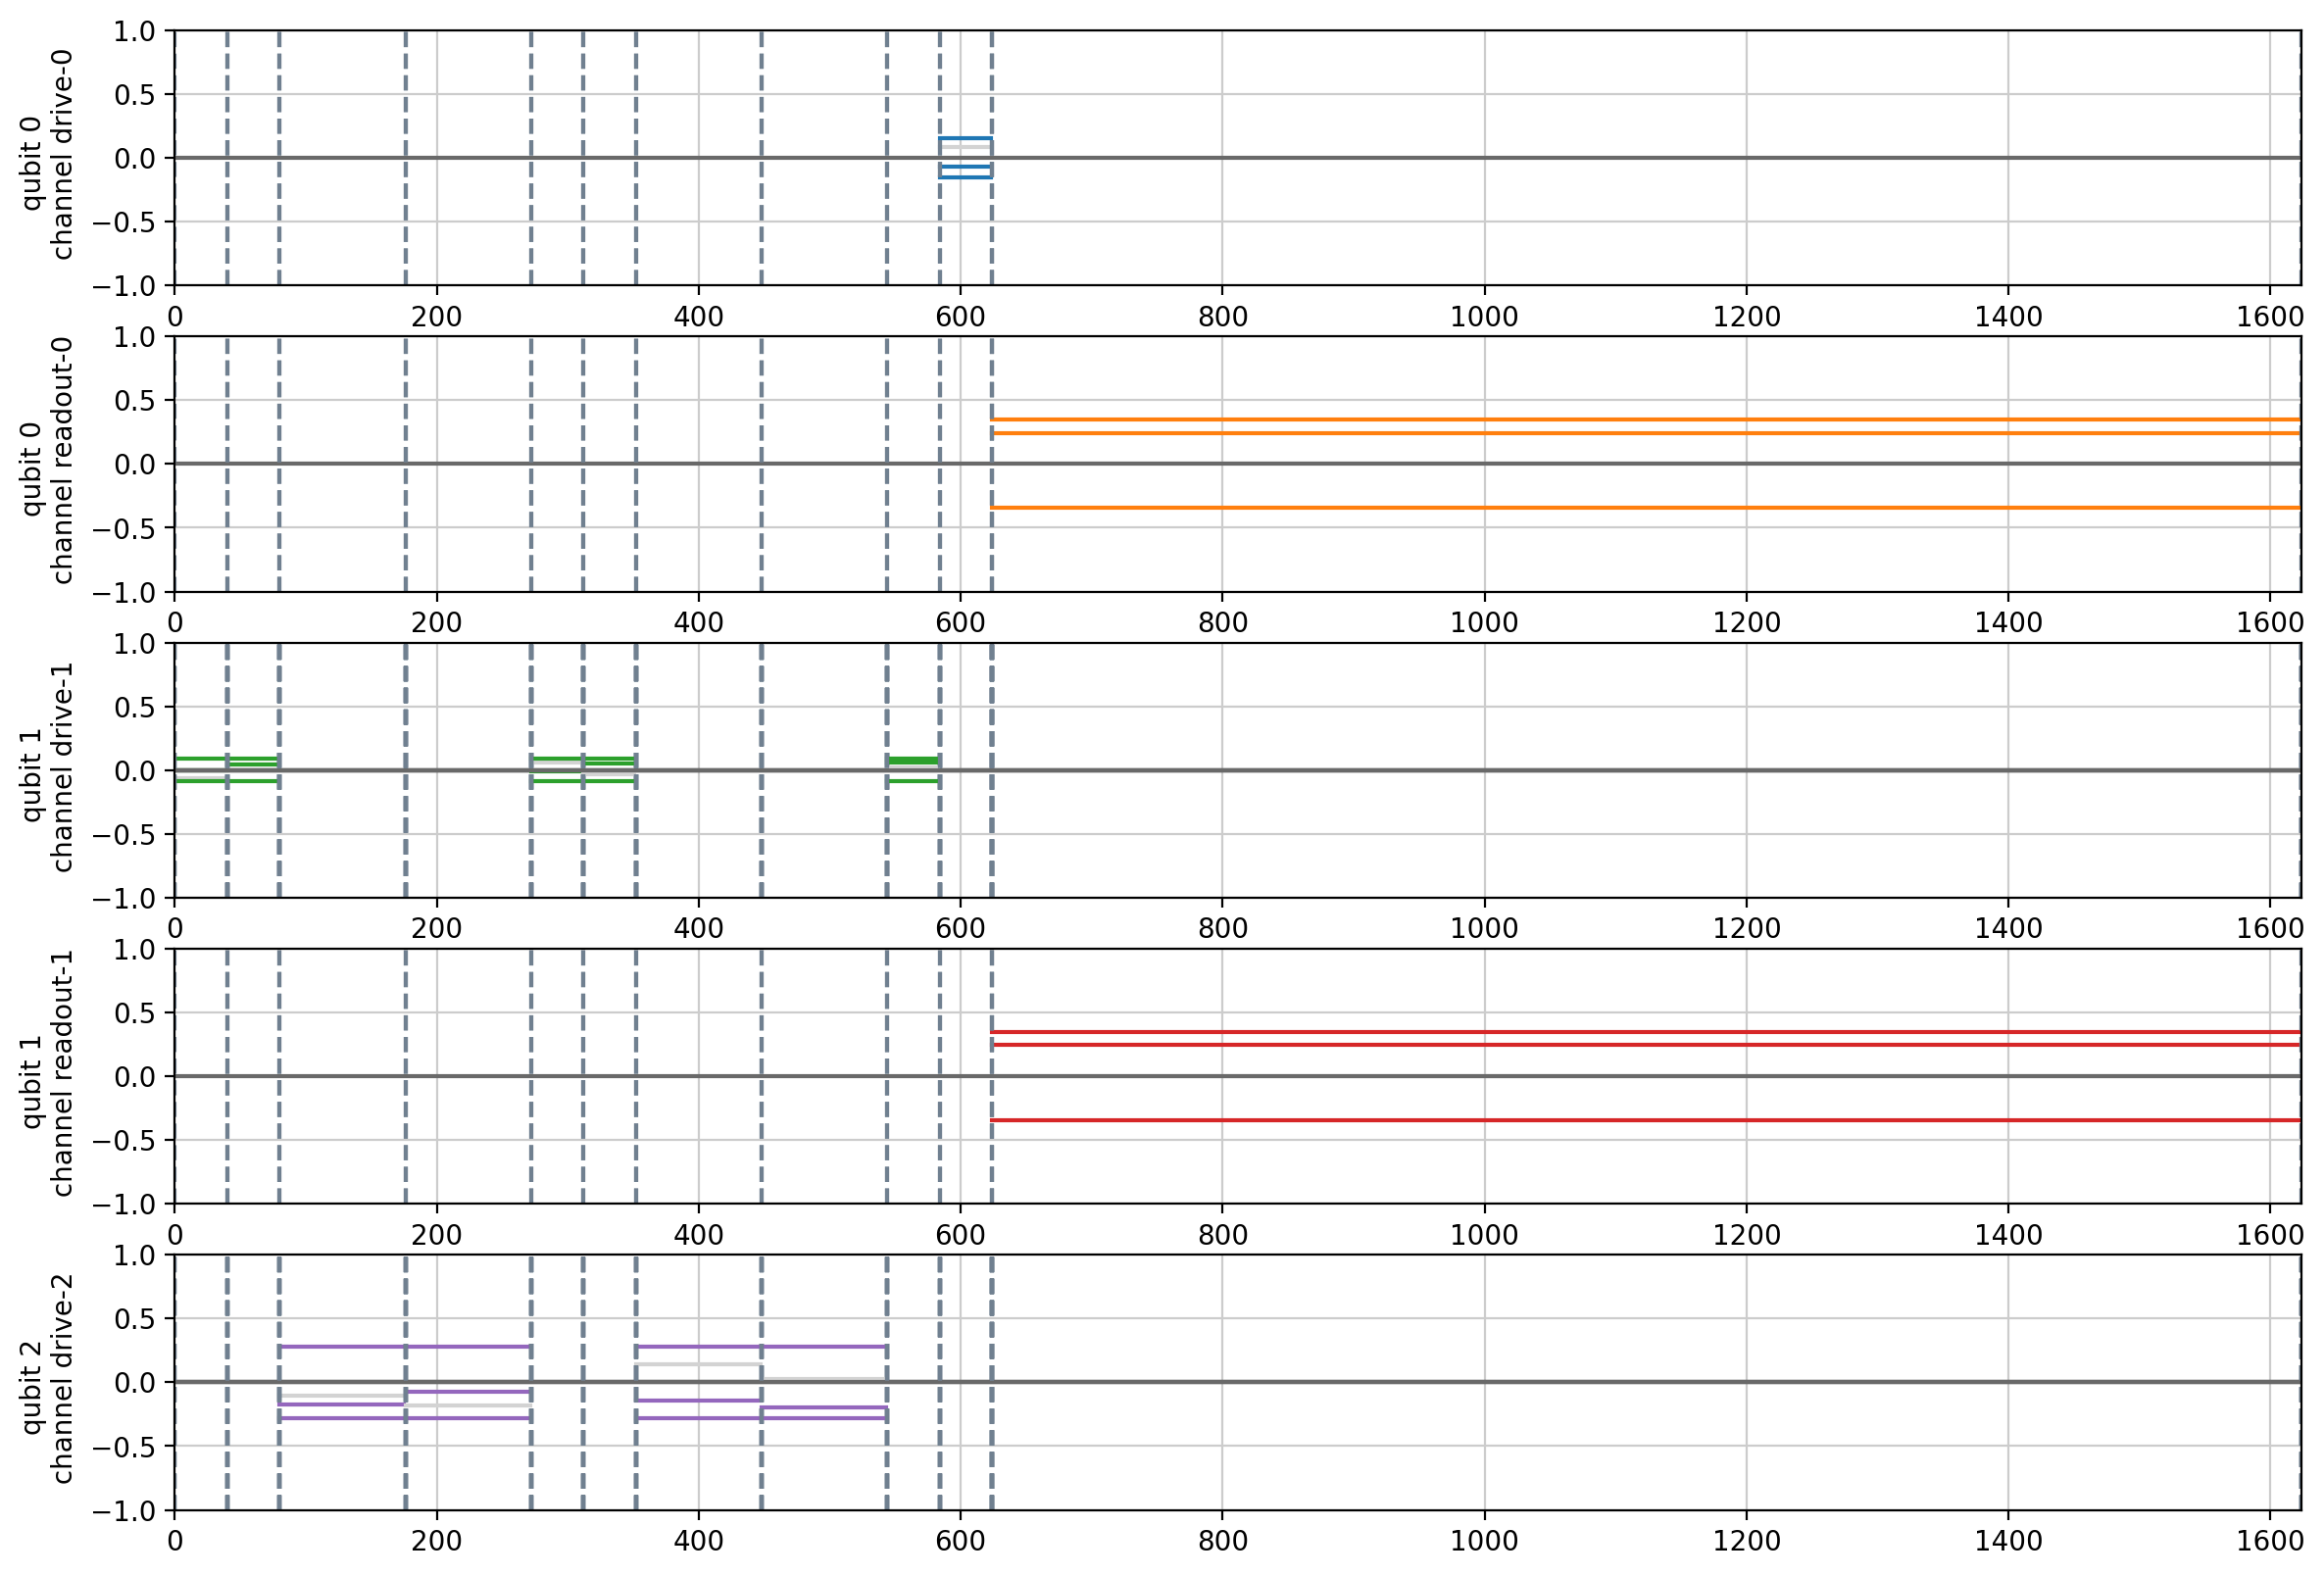

In [10]:
from qibolab.instruments.emulator.transpile_utils import get_pulse_sequence

# set the emulator platform and backend for this example
platform = platform_2q_CZ
backend = backend_2q_CZ

# get pulse sequence corresponding to the gates after transpiling to native pulses of the hardware
pulse_sequence = get_pulse_sequence(synth, backend, add_measure_all=True)

# show the pulse sequence organized into their various channels
print(pulse_sequence)
pulse_sequence.plot()

In [11]:
from qibolab.execution_parameters import ExecutionParameters

# settings
nshots=1000
options = ExecutionParameters(nshots=nshots)
platform.instruments['pulse_simulator'].output_state_history = True
platform.instruments['pulse_simulator'].simulate_dissipation = False

# execute pulse sequence on emulator
results = platform.execute_pulse_sequence(pulse_sequence, options=options)

[Qibo 0.2.16|INFO|2025-03-08 12:20:22]: Minimal execution time (sequence): 0.301624
INFO:qibo.config:Minimal execution time (sequence): 0.301624


PulseSequence
DrivePulse(0, 40, 0.086614, 5_675_200_000, 4.712389, Rectangular(), drive-1, 1)
DrivePulse(40, 40, 0.086614, 5_675_200_000, 7.068583, Rectangular(), drive-1, 1)
DrivePulse(80, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(176, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(272, 40, 0.086614, 5_675_200_000, 10.210176, Rectangular(), drive-1, 1)
DrivePulse(312, 40, 0.086614, 5_675_200_000, 14.137167, Rectangular(), drive-1, 1)
DrivePulse(352, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(448, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(544, 40, 0.086614, 5_675_200_000, 17.27876, Rectangular(), drive-1, 1)
DrivePulse(584, 40, 0.153543, 5_528_450_000, 4.712389, Rectangular(), drive-0, 0)
ReadoutPulse(624, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
ReadoutPulse(624, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-1, 1)
 [***      14%           ] Elapsed 9.42s / Rem

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*****    20%           ] Elapsed 12.79s / Remaining 00:00:00:51

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [******   27%           ] Elapsed 16.13s / Remaining 00:00:00:43

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [******** 34%           ] Elapsed 19.46s / Remaining 00:00:00:37

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********41%           ] Elapsed 22.95s / Remaining 00:00:00:33

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********48%           ] Elapsed 26.83s / Remaining 00:00:00:29

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********54%           ] Elapsed 30.40s / Remaining 00:00:00:25

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********60%**         ] Elapsed 33.49s / Remaining 00:00:00:22

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********67%***        ] Elapsed 36.81s / Remaining 00:00:00:18

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********75%*****      ] Elapsed 40.45s / Remaining 00:00:00:13

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********82%*******    ] Elapsed 43.99s / Remaining 00:00:00:09

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********89%********   ] Elapsed 47.79s / Remaining 00:00:00:05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:  55.11s*] Elapsed 55.11s / Remaining 00:00:00:00


Overlap of final state with basis states:
|00> 0.25552441228109357
|10> 0.25457707879911573
|20> 6.28253911741718e-05
|01> 0.24673863375159152
|11> 0.24269309249163923
|21> 6.007994028709952e-05
|02> 0.00017240618719642484
|12> 0.00017048547266955208
|22> 4.202712229161944e-08


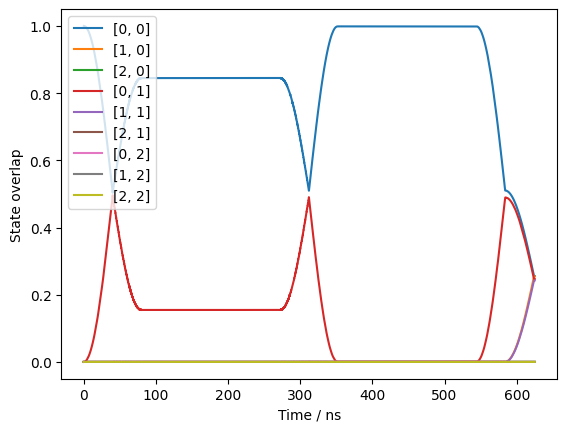

In [12]:
# visualize evolution of system's state during pulse sequence
from qibolab_visualization.emulator import plot_overlaps

simulation_results = results['simulation']
simulated_states = simulation_results['output_states']
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

simulation_engine = platform.instruments['pulse_simulator'].simulation_engine
overlaps = simulation_engine.compute_overlaps(simulated_states)

from qibolab_visualization.emulator import plot_overlaps
fig = plot_overlaps(overlaps,sim_time_list,time_label='Time / ns');

In [13]:
from qibolab.instruments.emulator.engines.qutip_engine import proj_to_2levelHS

# show density matrix of final state
final_state = simulated_states[-1]
proj_dm = proj_to_2levelHS(final_state)
print(np.round(proj_dm, precision))

[[ 0.256+0.j     0.243-0.078j -0.115-0.223j -0.176-0.176j]
 [ 0.243+0.078j  0.255+0.j    -0.042-0.247j -0.113-0.221j]
 [-0.115+0.223j -0.042+0.247j  0.247+0.j     0.233-0.074j]
 [-0.176+0.176j -0.113+0.221j  0.233+0.074j  0.243+0.j   ]]


#### Example 2b: n=4 qubits

For the n=4 case, we start by following closely the n=2 case:

In [14]:
nqubit = 4
# Synthesize the cudaq circuit (as input to the qibolab emulator)
synth = cudaq.synthesize(quantum_fourier_transform, nqubit)
 
# Draw the quantum circuit.
print(cudaq.draw(quantum_fourier_transform, nqubit))
 
# Compute the statevector and corresponding density matrix
statevector = np.array(cudaq.get_state(quantum_fourier_transform, nqubit))
density_matrix = np.outer(statevector, statevector.conjugate())

# print the density matrix to desired precision
precision = 3
print(np.round(density_matrix, precision))

     ╭───╮╭────────────╮╭───╮╭─────────────╮╭───╮╭────────────╮╭───╮»
q0 : ┤ h ├┤ rz(0.7854) ├┤ x ├┤ rz(-0.7854) ├┤ x ├┤ rz(0.3927) ├┤ x ├»
     ╰───╯╰────────────╯╰─┬─╯╰─────────────╯╰─┬─╯╰────────────╯╰─┬─╯»
q1 : ─────────────────────●───────────────────●──────────────────┼──»
                                                                 │  »
q2 : ────────────────────────────────────────────────────────────●──»
                                                                    »
q3 : ───────────────────────────────────────────────────────────────»
                                                                    »

################################################################################

╭─────────────╮╭───╮╭────────────╮╭───╮╭─────────────╮╭───╮                   »
┤ rz(-0.3927) ├┤ x ├┤ rz(0.1963) ├┤ x ├┤ rz(-0.1963) ├┤ x ├───────────────────»
╰─────────────╯╰─┬─╯╰────────────╯╰─┬─╯╰─────────────╯╰─┬─╯╭───╮╭────────────╮»
─────────────────┼──────────────────┼──────────

This time we will use the `platform_4q_CZ` emulator which has 4 qubits:

PulseSequence
DrivePulse(0, 40, 0.153543, 5_988_900_000, 4.712389, Rectangular(), drive-2, 2)
DrivePulse(40, 40, 0.153543, 5_988_900_000, 7.068583, Rectangular(), drive-2, 2)
DrivePulse(80, 96, 0.28125, 410_350_000, 5.497787, Rectangular(), drive-2, 2)
DrivePulse(80, 96, 0.28125, 410_350_000, 5.134535, Rectangular(), drive-2, 2)
DrivePulse(176, 40, 0.153543, 5_988_900_000, 10.210176, Rectangular(), drive-2, 2)
DrivePulse(216, 40, 0.153543, 5_988_900_000, 14.137167, Rectangular(), drive-2, 2)
DrivePulse(256, 96, 0.28125, 410_350_000, 12.566371, Rectangular(), drive-2, 2)
DrivePulse(256, 96, 0.28125, 410_350_000, 12.203119, Rectangular(), drive-2, 2)
DrivePulse(352, 40, 0.153543, 5_988_900_000, 17.27876, Rectangular(), drive-2, 2)
DrivePulse(352, 40, 0.086614, 5_433_800_000, 4.712389, Rectangular(), drive-3, 3)
DrivePulse(392, 40, 0.153543, 5_988_900_000, 20.027653, Rectangular(), drive-2, 2)
DrivePulse(392, 40, 0.086614, 5_433_800_000, 7.068583, Rectangular(), drive-3, 3)
DrivePulse(432

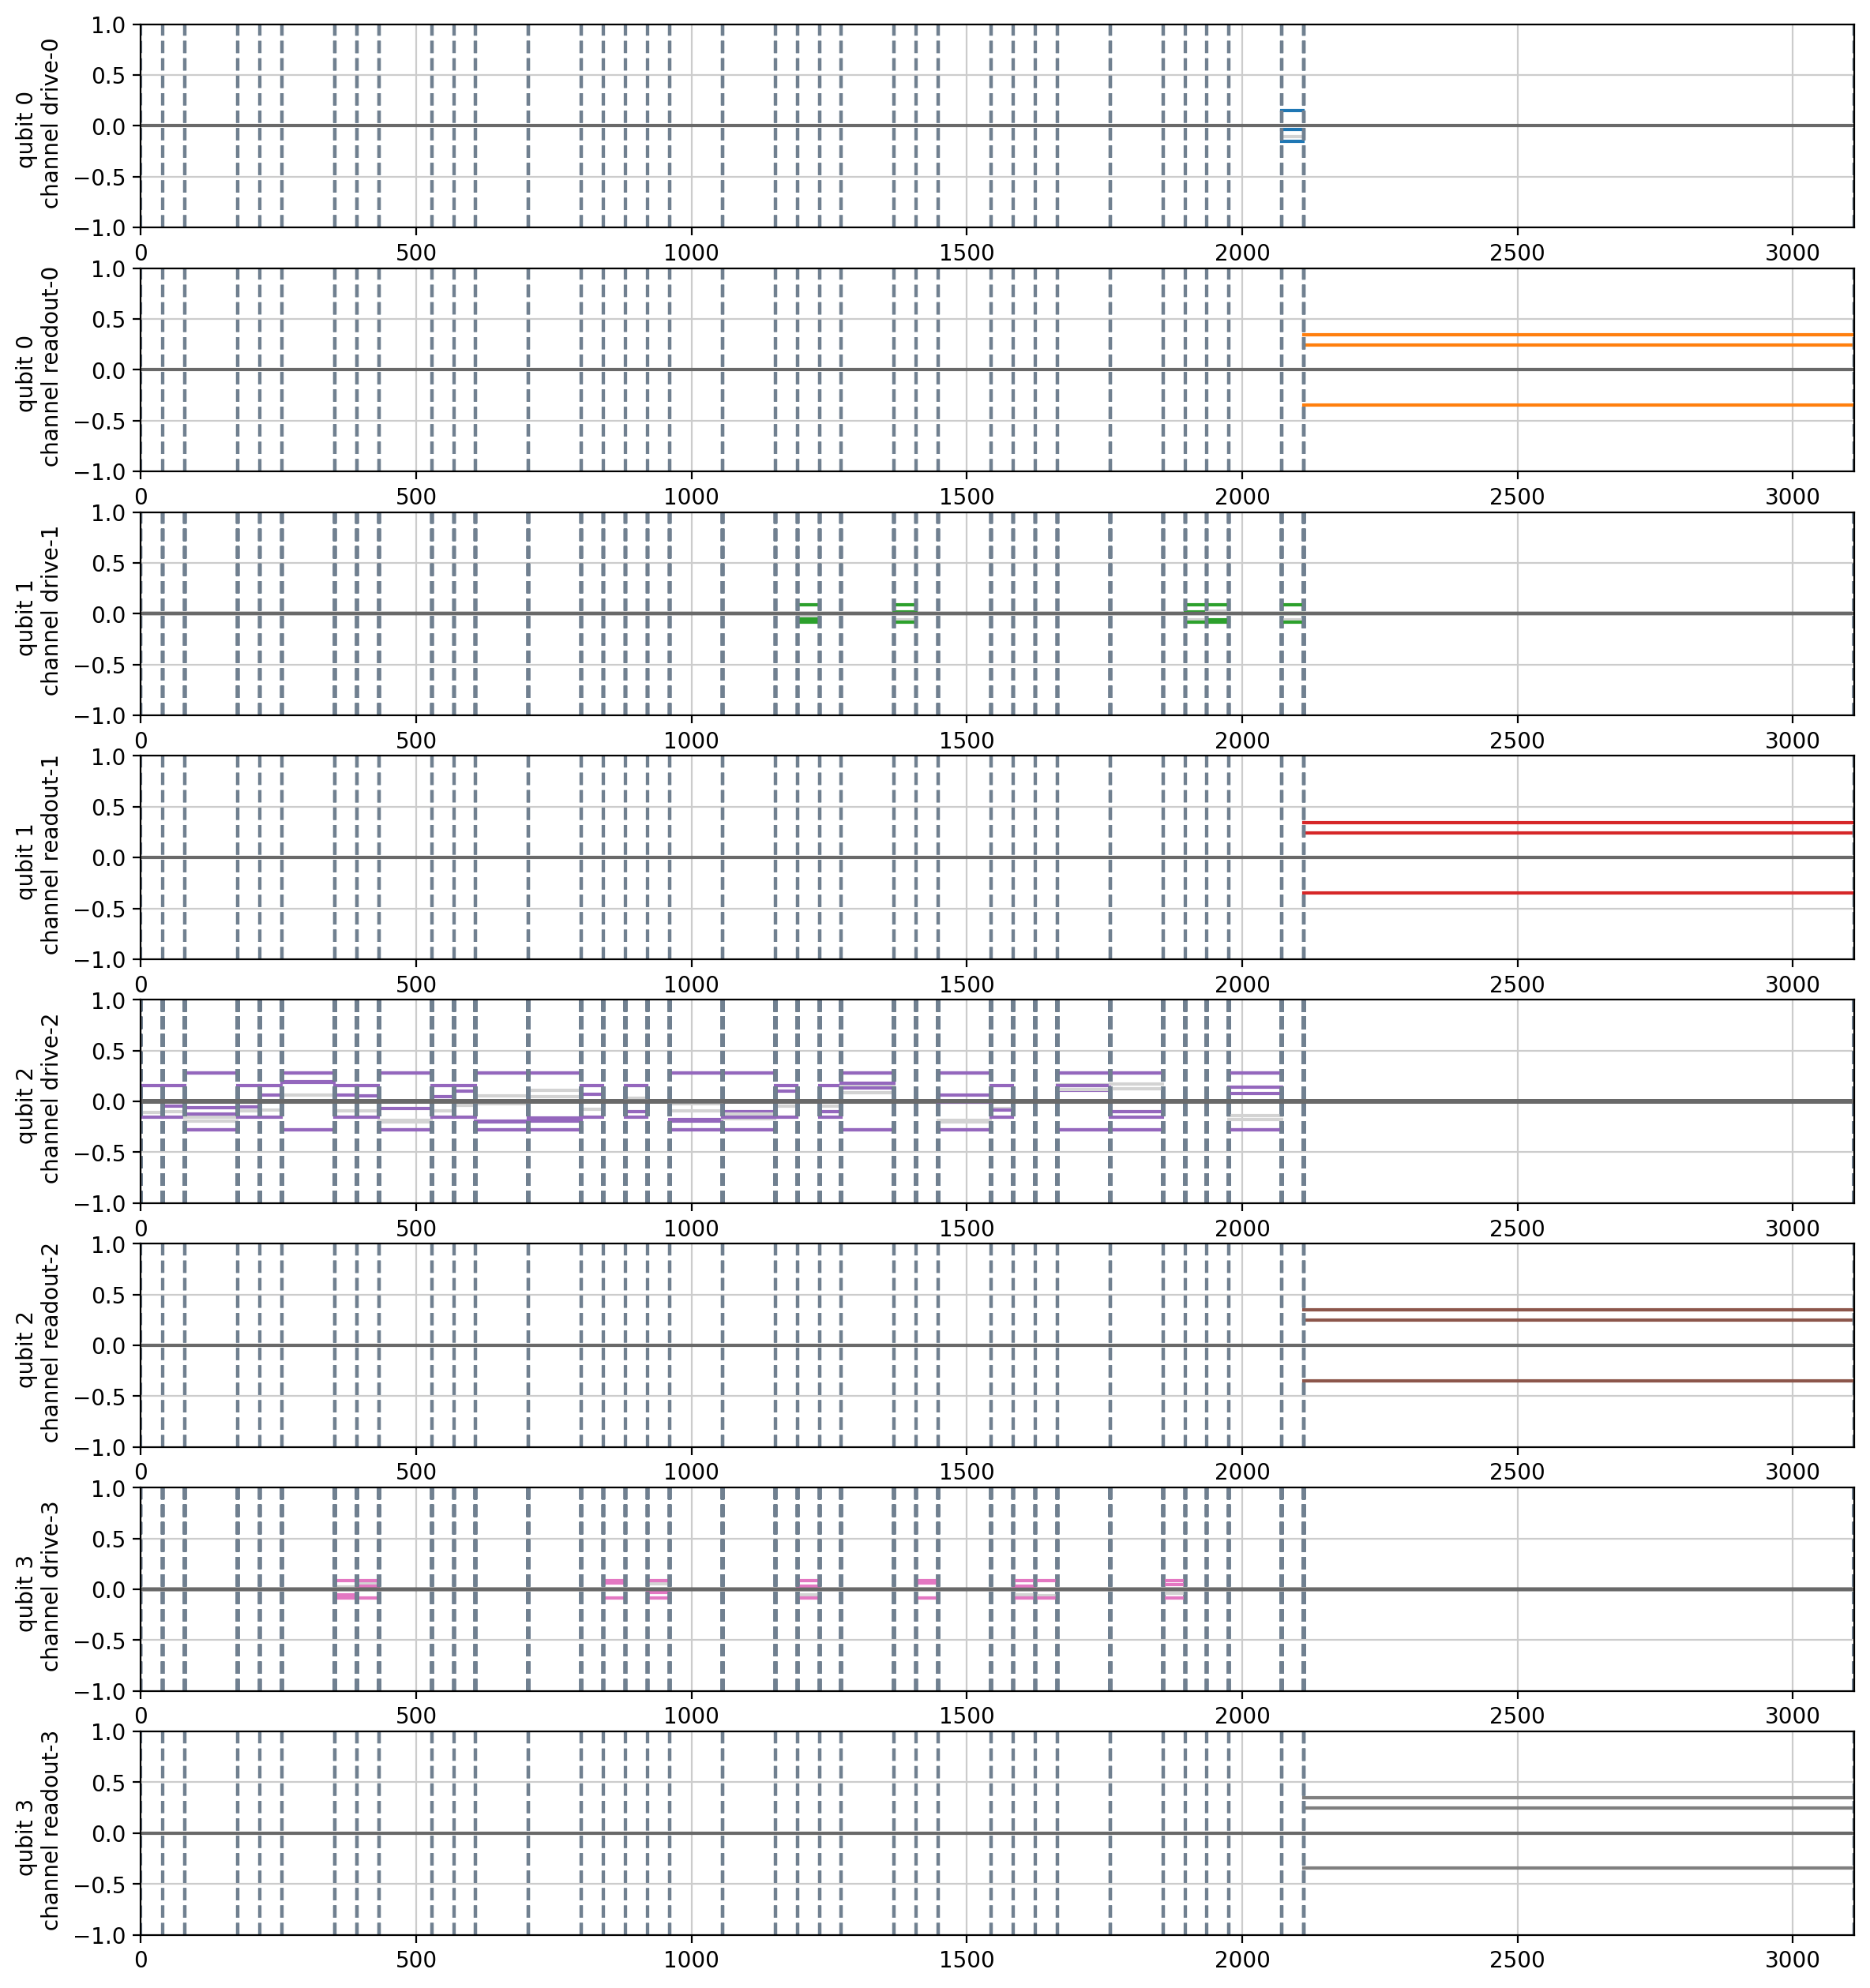

In [15]:
from qibolab.instruments.emulator.transpile_utils import get_pulse_sequence

# set the emulator platform and backend for this example
platform = platform_4q_CZ
backend = backend_4q_CZ

# get pulse sequence corresponding to the gates after transpiling to native pulses of the hardware
pulse_sequence = get_pulse_sequence(synth, backend, add_measure_all=True)

# show the pulse sequence organized into their various channels
print(pulse_sequence)
pulse_sequence.plot()

In [16]:
from qibolab.execution_parameters import ExecutionParameters

# settings
options = ExecutionParameters(nshots=1000)
platform.instruments['pulse_simulator'].output_state_history = True
platform.instruments['pulse_simulator'].simulate_dissipation = False

# execute pulse sequence on emulator
results = platform.execute_pulse_sequence(pulse_sequence, options=options)

[Qibo 0.2.16|INFO|2025-03-08 12:21:25]: Minimal execution time (sequence): 0.303112
INFO:qibo.config:Minimal execution time (sequence): 0.303112


PulseSequence
DrivePulse(0, 40, 0.153543, 5_988_900_000, 4.712389, Rectangular(), drive-2, 2)
DrivePulse(40, 40, 0.153543, 5_988_900_000, 7.068583, Rectangular(), drive-2, 2)
DrivePulse(80, 96, 0.28125, 410_350_000, 5.497787, Rectangular(), drive-2, 2)
DrivePulse(80, 96, 0.28125, 410_350_000, 5.134535, Rectangular(), drive-2, 2)
DrivePulse(176, 40, 0.153543, 5_988_900_000, 10.210176, Rectangular(), drive-2, 2)
DrivePulse(216, 40, 0.153543, 5_988_900_000, 14.137167, Rectangular(), drive-2, 2)
DrivePulse(256, 96, 0.28125, 410_350_000, 12.566371, Rectangular(), drive-2, 2)
DrivePulse(256, 96, 0.28125, 410_350_000, 12.203119, Rectangular(), drive-2, 2)
DrivePulse(352, 40, 0.153543, 5_988_900_000, 17.27876, Rectangular(), drive-2, 2)
DrivePulse(352, 40, 0.086614, 5_433_800_000, 4.712389, Rectangular(), drive-3, 3)
DrivePulse(392, 40, 0.153543, 5_988_900_000, 20.027653, Rectangular(), drive-2, 2)
DrivePulse(392, 40, 0.086614, 5_433_800_000, 7.068583, Rectangular(), drive-3, 3)
DrivePulse(432

In this case we hide the legend as the number of basis states for n=4 becomes too large for the legend to show properly.

Overlap of final state with basis states:
|0000> 0.06975046449988714
|1000> 0.06879037489304396
|2000> 1.5356281809744777e-05
|0100> 0.06610854007518241
|1100> 0.06519855326502087
|2100> 1.455446466729701e-05
|0200> 6.222067660805776e-05
|1200> 6.136383331535022e-05
|2200> 1.3698399120124032e-08
|0010> 0.06349274403239324
|1010> 0.0626188113381554
|2010> 1.3978580927735067e-05
|0110> 0.0601754023347834
|1110> 0.0593467753237281
|2110> 1.3248134182246568e-05
|0210> 5.6623342077771725e-05
|1210> 5.5841766710441835e-05
|2210> 1.2465604836836851e-08
|0020> 0.0013207860101734938
|1020> 0.0013026011420073271
|2020> 2.907829498323023e-07
|0120> 0.0012510824955088739
|1120> 0.0012338207534733005
|2120> 2.7542751410019617e-07
|0220> 1.1750522907742787e-06
|1220> 1.1587101817480605e-06
|2220> 2.5865511563902325e-10
|0001> 0.06401187339139802
|1001> 0.06313079542899569
|2001> 1.4092873556072483e-05
|0101> 0.060668879286859295
|1101> 0.05983351928844005
|2101> 1.335679476763194e-05
|0201> 5.709434

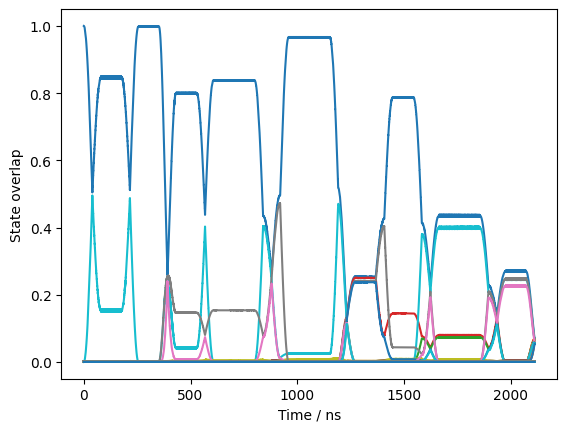

In [17]:
# visualize evolution of system's state during pulse sequence
from qibolab_visualization.emulator import plot_overlaps

simulation_results = results['simulation']
simulated_states = simulation_results['output_states']
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

simulation_engine = platform.instruments['pulse_simulator'].simulation_engine
overlaps = simulation_engine.compute_overlaps(simulated_states)

from qibolab_visualization.emulator import plot_overlaps
fig = plot_overlaps(overlaps,sim_time_list,time_label='Time / ns', show_legend=False, print_final_overlaps=True);

In [18]:
from qibolab.instruments.emulator.engines.qutip_engine import proj_to_2levelHS

# show density matrix of final state
final_state = simulated_states[-1]
proj_dm = proj_to_2levelHS(final_state)
print(np.round(proj_dm, precision))

[[ 0.07 +0.j    -0.014+0.068j -0.047+0.049j -0.038-0.056j  0.009+0.066j
  -0.066-0.005j -0.052-0.038j  0.048-0.043j -0.023+0.063j -0.056-0.035j
  -0.029-0.058j  0.063-0.016j -0.062-0.013j  0.026-0.058j  0.051-0.035j
   0.023+0.057j]
 [-0.014-0.068j  0.069+0.j     0.057+0.035j -0.046+0.048j  0.062-0.022j
   0.009+0.065j -0.026+0.059j -0.052-0.038j  0.066+0.009j -0.022+0.062j
  -0.051+0.04j  -0.029-0.057j -0.   +0.063j -0.061-0.013j -0.044-0.043j
   0.051-0.034j]
 [-0.047-0.049j  0.057-0.035j  0.066+0.j    -0.014+0.064j  0.04 -0.051j
   0.041+0.05j   0.008+0.063j -0.062-0.005j  0.059-0.027j  0.013+0.063j
  -0.021+0.06j  -0.053-0.033j  0.033+0.053j -0.058+0.021j -0.059-0.013j
   0.025-0.055j]
 [-0.038+0.056j -0.046-0.048j -0.014-0.064j  0.065+0.j    -0.058-0.029j
   0.04 -0.05j   0.059-0.021j  0.008+0.062j -0.038-0.052j  0.059-0.026j
   0.062+0.008j -0.021+0.059j  0.045-0.043j  0.032+0.052j -0.   +0.06j
  -0.058-0.013j]
 [ 0.009-0.066j  0.062+0.022j  0.04 +0.051j -0.058+0.029j  0.063+0.j


## Pulse-level control on the Qibolab emulator

In the following 2 examples, we showcase the pulse-level control provided by the Qibolab emulator as well as several of its other features

### Example 3: Bell circuit pulse sequence (RX180 + SiSWAP)

In this example, we construct the pulse sequence corresponding to a bell state preparation for the anyon QPU `backend_2q_iSWAP`, with a native fSim gate in the iSWAP-like configuration. For purposes of this tutorial, we can treat this as an iSWAP gate. This can be achieved by first applying an RX180 pulse on either of the two 2 qubits, followed by the iSWAP pulse but at half its calibrated duration, which effectively achieves the square root iSWAP gate (SiSWAP). This achieves a maximally entangled state between $\ket{01}$ and $\ket{10}$.

PulseSequence
DrivePulse(0, 40, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
DrivePulse(45, 100.0, 0.28125, 73_200_000, 0, Rectangular(), drive-2, 2)
ReadoutPulse(145, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
ReadoutPulse(145, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-1, 1)


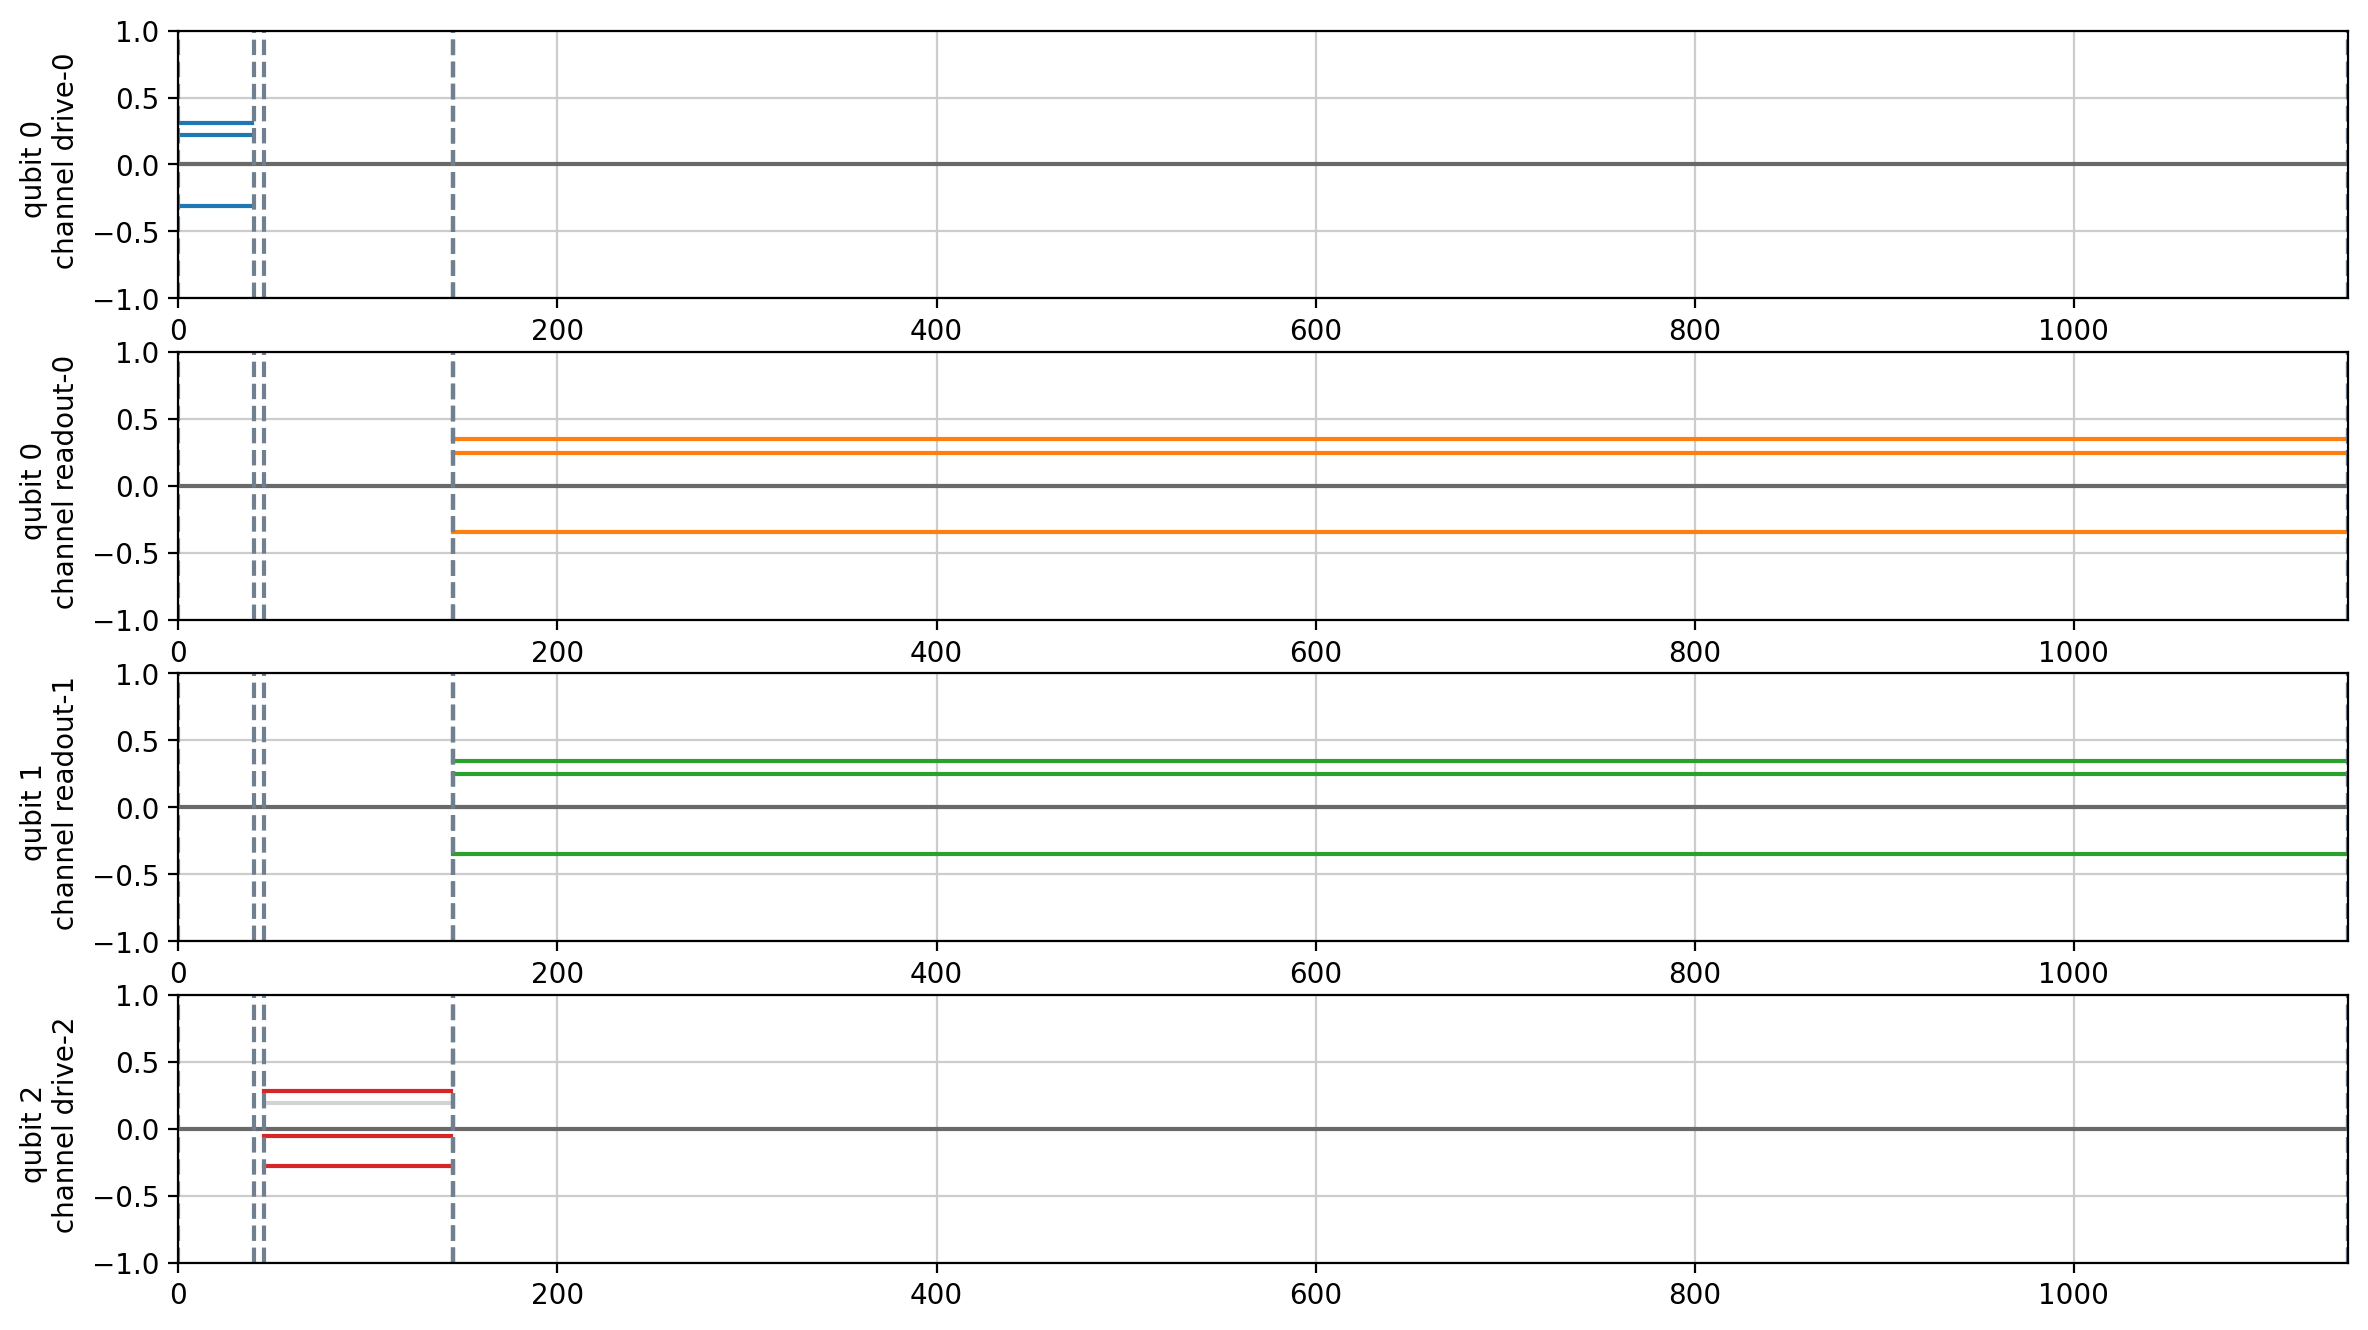

In [19]:
# Set the emulator platform and backend for this example
platform = platform_2q_iSWAP
backend = backend_2q_iSWAP

from qibolab.pulses import PulseSequence, DrivePulse

# Load calibrated iSWAP pulse
iswap_pulse = platform.create_iSWAP_pulse_sequence(qubits=[0,1],start=0)[0][0]

# Construct pulses accounting for their start times
duration = 5
pulse_x0 = platform.create_RX_pulse(qubit=0, start=0)
duration += pulse_x0.duration

# Manually construct SiSWAP pulse from calibrated iSWAP pulse by halving its duration while keeping all other settings the same
pulse_siswap01 = DrivePulse(start=int(duration),
                       duration=iswap_pulse.duration/2, 
                       amplitude=iswap_pulse.amplitude,
                       frequency=iswap_pulse.frequency,
                       relative_phase=iswap_pulse.relative_phase,
                       shape=iswap_pulse.shape,
                       channel=iswap_pulse.channel,
                       qubit=iswap_pulse.qubit)
duration += pulse_siswap01.duration

# Add readout pulses for both qubits
pulse_r0 = platform.create_qubit_readout_pulse(qubit=0, start=int(duration))
pulse_r1 = platform.create_qubit_readout_pulse(qubit=1, start=int(duration))

# Construct PulseSequence by adding pulses in order
pulse_sequence = PulseSequence()
pulse_sequence.add(pulse_x0)
pulse_sequence.add(pulse_siswap01)
pulse_sequence.add(pulse_r0)
pulse_sequence.add(pulse_r1)

# Show the pulse sequence organized into their various channels
print(pulse_sequence)
pulse_sequence.plot()

Next we execute the pulse sequence and check its results as with before. In this example, let's turn on the dissipation effects:

In [20]:
from qibolab.execution_parameters import ExecutionParameters

# Execution settings
nshots = 2975
options = ExecutionParameters(nshots=nshots)
platform.instruments['pulse_simulator'].output_state_history = True
platform.instruments['pulse_simulator'].simulate_dissipation = True

# Execute pulse sequence on emulator
results = platform.execute_pulse_sequence(pulse_sequence, options=options)

[Qibo 0.2.16|INFO|2025-03-08 12:27:12]: Minimal execution time (sequence): 0.895906375
INFO:qibo.config:Minimal execution time (sequence): 0.895906375


PulseSequence
DrivePulse(0, 40, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
DrivePulse(45, 100.0, 0.28125, 73_200_000, 0, Rectangular(), drive-2, 2)
ReadoutPulse(145, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
ReadoutPulse(145, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-1, 1)
 [******** 35%           ] Elapsed 5.35s / Remaining 00:00:00:09

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********52%           ] Elapsed 7.26s / Remaining 00:00:00:06

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********66%***        ] Elapsed 8.75s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********85%********   ] Elapsed 10.66s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********99%***********] Elapsed 12.18s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Overlap of final state with basis states:
|00> 0.00574171786278841
|10> 0.4969510672806707
|20> 0.0009502634948887289
|01> 0.4963567752847714
|11> 1.760580298573816e-07
|21> 0.0
|02> 1.8852629092621986e-11
|12> 0.0
|22> 0.0


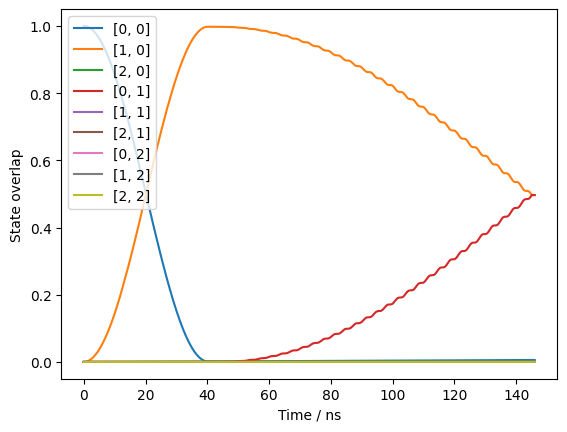

In [21]:
import numpy as np

simulation_results = results['simulation']
simulated_states = simulation_results['output_states']
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

simulation_engine = platform.instruments['pulse_simulator'].simulation_engine
overlaps = simulation_engine.compute_overlaps(simulated_states)

from qibolab_visualization.emulator import plot_overlaps
fig = plot_overlaps(overlaps,sim_time_list,time_label='Time / ns');

In [22]:
from qibolab.instruments.emulator.engines.qutip_engine import proj_to_2levelHS

# show density matrix of final state
precision = 3
final_state = simulated_states[-1]
proj_dm = proj_to_2levelHS(final_state)
print(np.round(proj_dm, precision))

[[ 0.006-0.j    -0.   +0.017j -0.01 -0.013j  0.   -0.j   ]
 [-0.   -0.017j  0.497+0.j    -0.394+0.3j   -0.   -0.j   ]
 [-0.01 +0.013j -0.394-0.3j    0.496+0.j    -0.   +0.j   ]
 [ 0.   +0.j    -0.   +0.j    -0.   -0.j     0.   +0.j   ]]


The same pulse sequence, followed by state tomography, was executed on the Anyon QPU to obtain the density matrix of the bell state. The results are subjected to readout fidelity of ~98% on each of the qubits:

In [23]:
qpu_result = np.array([[ 0.028+0.j,    0.005-0.003j, 0.005-0.005j, 0.  -0.002j],
[ 0.005+0.003j, 0.478+0.j,   -0.007+0.462j, 0.003-0.003j],
[ 0.005+0.005j, -0.007-0.462j, 0.482+0.j,    0.003-0.003j],
[ 0.  +0.002j, 0.003+0.003j, 0.003+0.003j, 0.011+0.j]])

np.diag(qpu_result)

array([0.028+0.j, 0.478+0.j, 0.482+0.j, 0.011+0.j])

To compare with QPU results, we will need to sample the final density matrix obtained from the emulator with readout error. Rather than simulating full state tomography on the emulator, we show here the sampled results of the measurement in the ZZ basis:

In [24]:
samples_q0_q1 = np.transpose([results[0].samples, results[1].samples])
bitstrings = ["".join(map(str, i)) for i in samples_q0_q1]
outcomes = np.sort(list(set(bitstrings))).tolist()
readout_counts = {item: bitstrings.count(item)/nshots for item in outcomes}
readout_counts

{'00': 0.02857142857142857,
 '01': 0.4789915966386555,
 '10': 0.4726050420168067,
 '11': 0.019831932773109243}

### Example 4: Mixed gate and pulse, selected measurement

In this example we show how mixed gate and pulse inputs can be executed on the emulator. We first construct the cudaq circuit with and X gate on qubit 0 and a SWAP gate:

In [25]:
import cudaq
import numpy as np

# Construct bell circuit
swap_circuit = cudaq.make_kernel()
qubits = swap_circuit.qalloc(2)
swap_circuit.x(qubits[0])
swap_circuit.swap(qubits[0], qubits[1]) 

# Set computation backend. Can be changed to 'nvidia' for single gpu, 'nvidia-mgpu' for multi-GPU or quantum hardware.
cudaq.set_target("qpp-cpu")
 
# Draw the quantum circuit.
print(cudaq.draw(swap_circuit))

# Compute the statevector and corresponding density matrix
statevector = np.array(cudaq.get_state(swap_circuit)) 
density_matrix = np.outer(statevector, statevector.conjugate())

# print the density matrix to desired precision
precision = 3
print(np.round(density_matrix, precision))

     ╭───╮   
q0 : ┤ x ├─╳─
     ╰───╯ │ 
q1 : ──────╳─
             

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


PulseSequence
DrivePulse(0, 40, 0.153543, 5_528_450_000, 1.570796, Rectangular(), drive-0, 0)
DrivePulse(40, 40, 0.153543, 5_528_450_000, 1.570796, Rectangular(), drive-0, 0)
DrivePulse(40, 40, 0.086614, 5_675_200_000, 4.712389, Rectangular(), drive-1, 1)
DrivePulse(80, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(176, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(272, 40, 0.153543, 5_528_450_000, 7.853982, Rectangular(), drive-0, 0)
DrivePulse(272, 40, 0.086614, 5_675_200_000, 7.853982, Rectangular(), drive-1, 1)
DrivePulse(312, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(408, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(504, 40, 0.153543, 5_528_450_000, 10.995574, Rectangular(), drive-0, 0)
DrivePulse(504, 40, 0.086614, 5_675_200_000, 10.995574, Rectangular(), drive-1, 1)
DrivePulse(544, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(640, 96, 0.28125, 219_824_000, 0, Rectangula

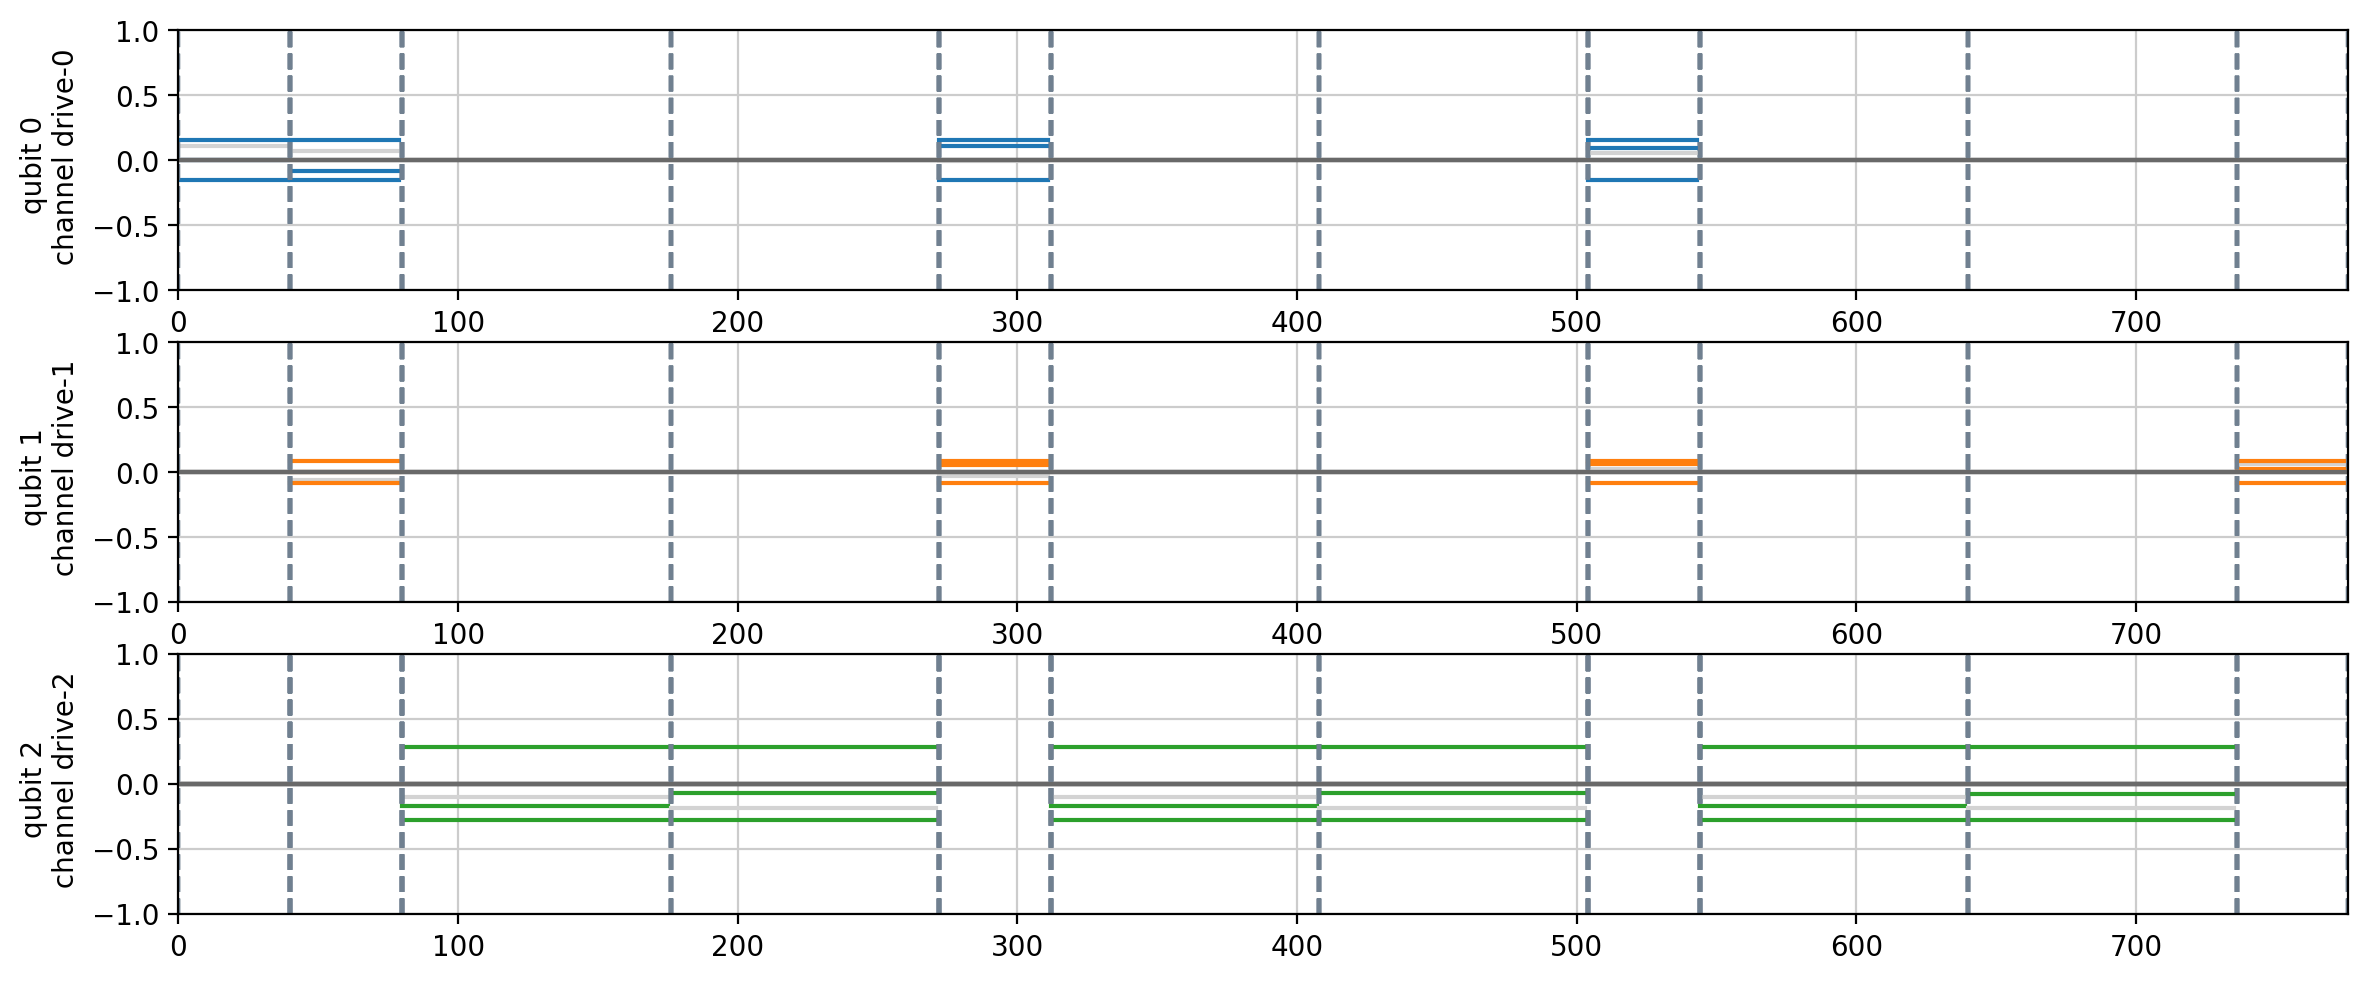

In [26]:
from qibolab.instruments.emulator.transpile_utils import get_pulse_sequence

# set the emulator platform and backend for this example
platform = platform_2q_CZ
backend = backend_2q_CZ

# get pulse sequence corresponding to the gates after transpiling to native pulses of the hardware
pulse_sequence = get_pulse_sequence(swap_circuit, backend, add_measure_all=False)

# show the pulse sequence organized into their various channels
print(pulse_sequence)
pulse_sequence.plot()

Note that during transpilation, there is a chance that qubits 0 gets remapped to qubit 1 and vice versa when the transpiler determines the optimal remapping of qubits based on the circuit. Recall from the circuit construction, the first gate was X on qubit 0 and by comparing with the first pulse, if it is instead on qubit 1, then we know that the 0<>1 remap occured.

We add to the pulse sequence from the transpiled circuit, an RX180 pulse on qubit 1, followed by a readout pulse on qubit 1, and plot the full pulse sequence.
- If the 0<>1 remap does not happen, we expect to be in the $\ket{00}$ state after the full pulse sequence and qubit 1 readout is expected to always give 0.
- If the 0<>1 remap happens, we expect to be in the $\ket{11}$ state after the full pulse sequence and qubit 1 readout is expected to always give 1.

PulseSequence
DrivePulse(0, 40, 0.153543, 5_528_450_000, 1.570796, Rectangular(), drive-0, 0)
DrivePulse(40, 40, 0.153543, 5_528_450_000, 1.570796, Rectangular(), drive-0, 0)
DrivePulse(40, 40, 0.086614, 5_675_200_000, 4.712389, Rectangular(), drive-1, 1)
DrivePulse(80, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(176, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(272, 40, 0.153543, 5_528_450_000, 7.853982, Rectangular(), drive-0, 0)
DrivePulse(272, 40, 0.086614, 5_675_200_000, 7.853982, Rectangular(), drive-1, 1)
DrivePulse(312, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(408, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(504, 40, 0.153543, 5_528_450_000, 10.995574, Rectangular(), drive-0, 0)
DrivePulse(504, 40, 0.086614, 5_675_200_000, 10.995574, Rectangular(), drive-1, 1)
DrivePulse(544, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(640, 96, 0.28125, 219_824_000, 0, Rectangula

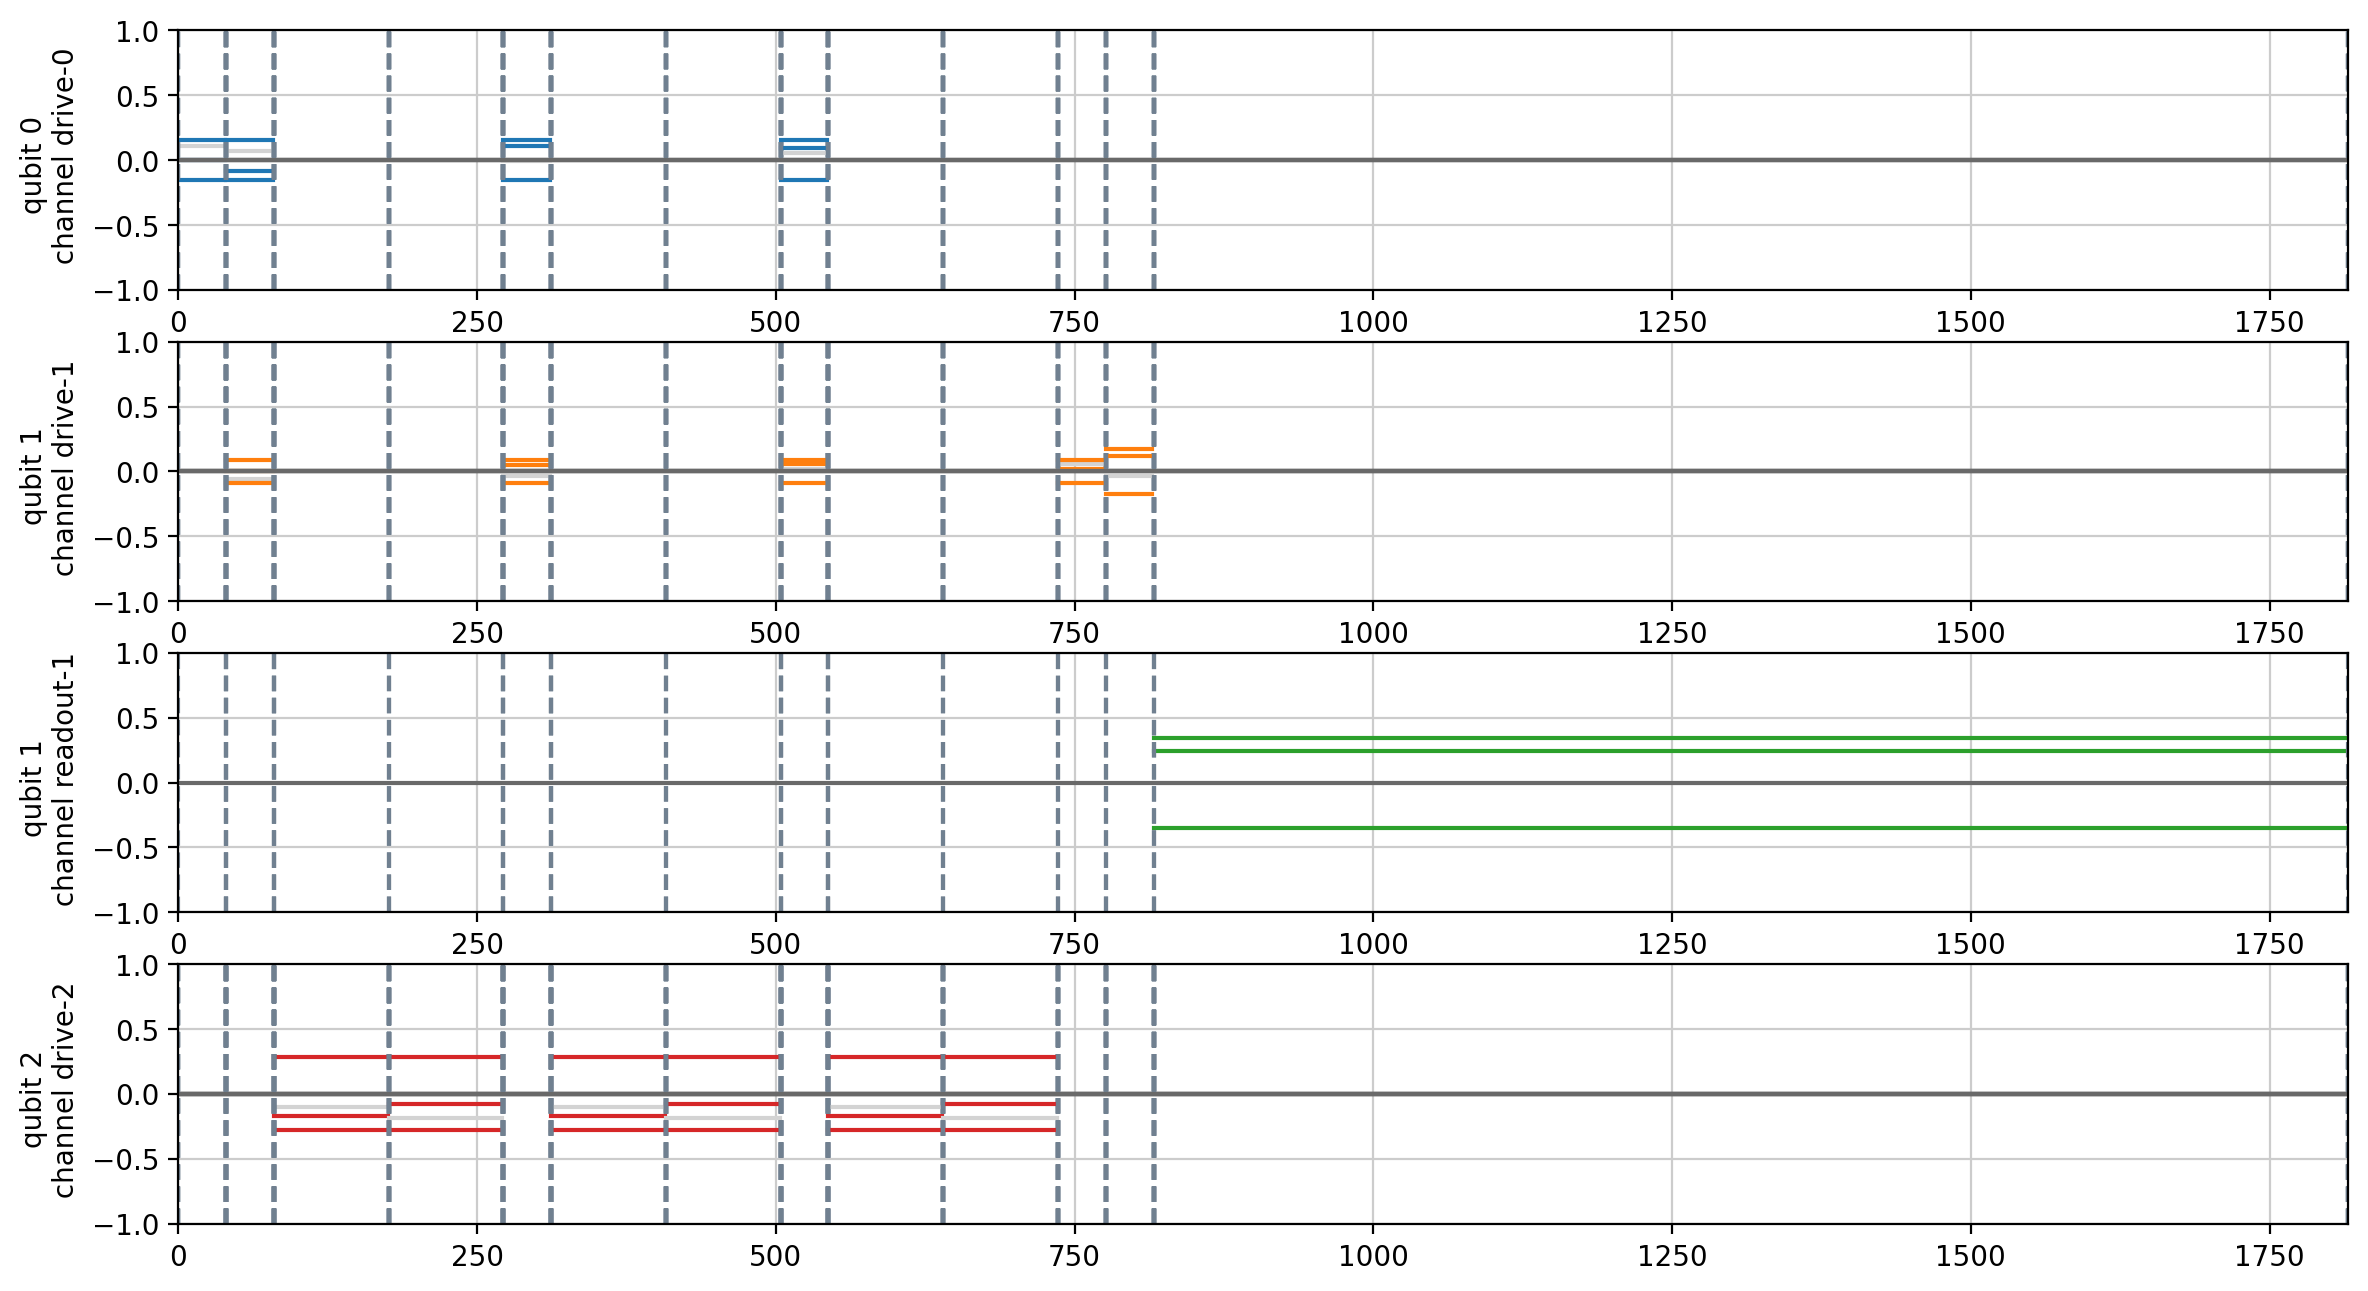

In [27]:
# Manually add on RX180 and readout pulse only on qubit 1
from qibolab.pulses import PulseSequence, DrivePulse

# Extract preset pulses from runcard
duration = pulse_sequence.duration
pulse_x1 = platform.create_RX_pulse(qubit=1, start=duration)
duration += pulse_x1.duration
pulse_r1 = platform.create_qubit_readout_pulse(qubit=1, start=int(duration))

# Add pulses to PulseSequence
pulse_sequence.add(pulse_x1)
pulse_sequence.add(pulse_r1)

# show the pulse sequence organized into their various channels
print(pulse_sequence)
pulse_sequence.plot()

We run the simulation and show how the state evolves in time:

In [28]:
from qibolab.execution_parameters import ExecutionParameters

# settings
options = ExecutionParameters(nshots=1000)
platform.instruments['pulse_simulator'].output_state_history = True
platform.instruments['pulse_simulator'].simulate_dissipation = False

# execute pulse sequence on emulator
results = platform.execute_pulse_sequence(pulse_sequence, options=options)

[Qibo 0.2.16|INFO|2025-03-08 12:27:27]: Minimal execution time (sequence): 0.30181600000000003
INFO:qibo.config:Minimal execution time (sequence): 0.30181600000000003


PulseSequence
DrivePulse(0, 40, 0.153543, 5_528_450_000, 1.570796, Rectangular(), drive-0, 0)
DrivePulse(40, 40, 0.153543, 5_528_450_000, 1.570796, Rectangular(), drive-0, 0)
DrivePulse(40, 40, 0.086614, 5_675_200_000, 4.712389, Rectangular(), drive-1, 1)
DrivePulse(80, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(176, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(272, 40, 0.153543, 5_528_450_000, 7.853982, Rectangular(), drive-0, 0)
DrivePulse(272, 40, 0.086614, 5_675_200_000, 7.853982, Rectangular(), drive-1, 1)
DrivePulse(312, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(408, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(504, 40, 0.153543, 5_528_450_000, 10.995574, Rectangular(), drive-0, 0)
DrivePulse(504, 40, 0.086614, 5_675_200_000, 10.995574, Rectangular(), drive-1, 1)
DrivePulse(544, 96, 0.28125, 219_824_000, 0, Rectangular(), drive-2, 2)
DrivePulse(640, 96, 0.28125, 219_824_000, 0, Rectangula

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [****     16%           ] Elapsed 13.45s / Remaining 00:00:01:10

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*****    21%           ] Elapsed 17.09s / Remaining 00:00:01:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [******   25%           ] Elapsed 20.66s / Remaining 00:00:01:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*******  30%           ] Elapsed 24.25s / Remaining 00:00:00:56

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********41%           ] Elapsed 34.78s / Remaining 00:00:00:50

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********49%           ] Elapsed 41.05s / Remaining 00:00:00:42

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********54%           ] Elapsed 44.72s / Remaining 00:00:00:38

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********58%*          ] Elapsed 48.06s / Remaining 00:00:00:34

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********63%**         ] Elapsed 51.87s / Remaining 00:00:00:30

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********68%****       ] Elapsed 56.09s / Remaining 00:00:00:26

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********74%*****      ] Elapsed 60.05s / Remaining 00:00:00:21

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********79%******     ] Elapsed 63.82s / Remaining 00:00:00:16

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********83%*******    ] Elapsed 67.39s / Remaining 00:00:00:13

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********88%********   ] Elapsed 71.21s / Remaining 00:00:00:09

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:  82.12s*] Elapsed 82.12s / Remaining 00:00:00:00


Overlap of final state with basis states:
|00> 0.9956049521359362
|10> 0.000140462483105771
|20> 1.3880912272671135e-05
|01> 0.0012738194799160572
|11> 0.0003803050064949578
|21> 0.0009889496398001617
|02> 0.0008435771413835976
|12> 0.0007272144566698014
|22> 9.269621050339893e-07


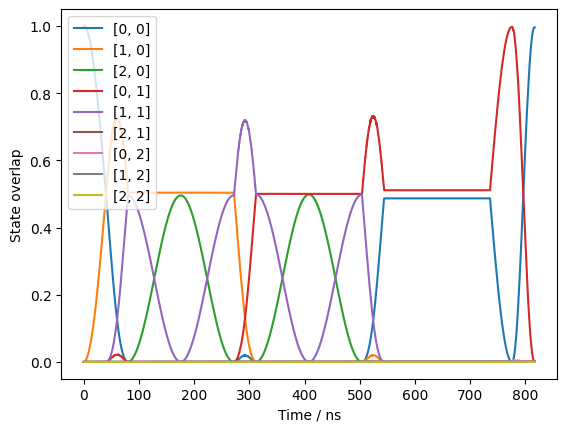

In [29]:
import numpy as np

simulation_results = results['simulation']
simulated_states = simulation_results['output_states']
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

simulation_engine = platform.instruments['pulse_simulator'].simulation_engine
overlaps = simulation_engine.compute_overlaps(simulated_states)

from qibolab_visualization.emulator import plot_overlaps
fig = plot_overlaps(overlaps,sim_time_list,time_label='Time / ns');

In this run, the exchange did not happen during transpilation and we find the expected final state $\ket{00}$ with an amplitude of 0.996.

We can also look at the outcome samples based on nshots=1000. In this case, the bitstring returned corresponds to the 1000 readout samples of qubit 1 where we added the readout pulse to, with a 2% readout error:

In [30]:
bitstring = results[1].samples.tolist()
{i:bitstring.count(i) for i in set(bitstring)}

{0: 980, 1: 20}

### Example 5: Qibocal rabi experiment

Finally, we can leverage on calibration protocols provided by the qibocal repository. Below is a brief demonstration of the rabi experiment on qubit 0 of `platform_2q_CZ` using qibocal, where we perform a sweep across different pulse duration to determine the optimum RX180 pulse duration:

In [31]:
import qibocal.protocols.rabi as rabi

platform = platform_2q_CZ

experiment = rabi.length_sequences
parameters = experiment.rabi_length_sequences.parameters_type.load(dict(
    pulse_duration_end=100,
    pulse_duration_start=1,
    pulse_duration_step=2,
    nshots=1024,
))
qubits = platform.qubits

platform.connect() # does nothing for the emulator, only applicable for actual QPUs
data, acquisition_time = experiment.rabi_length_sequences.acquisition(params=parameters, platform=platform, targets={0:qubits[0]})
platform.disconnect() # does nothing for the emulator, only applicable for actual QPUs

[Qibo 0.2.16|INFO|2025-03-08 12:28:53]: Loading platform dummy
INFO:qibo.config:Loading platform dummy
[Qibo 0.2.16|INFO|2025-03-08 12:28:53]: Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x7fa7f418d060>.
INFO:qibo.config:Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x7fa7f418d060>.
[Qibo 0.2.16|INFO|2025-03-08 12:28:53]: Minimal execution time (sequence): 0.308225024
INFO:qibo.config:Minimal execution time (sequence): 0.308225024


PulseSequence
DrivePulse(0, 1, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(1, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [********100%***********] Elapsed 0.10s / Remaining 00:00:00:00

[Qibo 0.2.16|INFO|2025-03-08 12:28:53]: Minimal execution time (sequence): 0.30822707200000005
INFO:qibo.config:Minimal execution time (sequence): 0.30822707200000005


 Total run time:   0.10s
PulseSequence
DrivePulse(0, 3, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(3, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 Total run time:   0.23s*] Elapsed 0.23s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:28:53]: Minimal execution time (sequence): 0.30822912
INFO:qibo.config:Minimal execution time (sequence): 0.30822912


PulseSequence
DrivePulse(0, 5, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(5, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 Total run time:   0.38s*] Elapsed 0.38s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:28:54]: Minimal execution time (sequence): 0.308231168
INFO:qibo.config:Minimal execution time (sequence): 0.308231168


PulseSequence
DrivePulse(0, 7, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(7, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 Total run time:   0.51s*] Elapsed 0.51s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:28:54]: Minimal execution time (sequence): 0.30823321600000003
INFO:qibo.config:Minimal execution time (sequence): 0.30823321600000003


PulseSequence
DrivePulse(0, 9, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(9, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.04s*] Elapsed 1.04s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:28:57]: Minimal execution time (sequence): 0.30823936
INFO:qibo.config:Minimal execution time (sequence): 0.30823936


PulseSequence
DrivePulse(0, 15, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(15, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 Total run time:   1.28s*] Elapsed 1.28s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:28:58]: Minimal execution time (sequence): 0.308241408
INFO:qibo.config:Minimal execution time (sequence): 0.308241408


PulseSequence
DrivePulse(0, 17, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(17, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*******  31%           ] Elapsed 0.47s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.65s*] Elapsed 1.65s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:01]: Minimal execution time (sequence): 0.308245504
INFO:qibo.config:Minimal execution time (sequence): 0.308245504


PulseSequence
DrivePulse(0, 21, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(21, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [********100%***********] Elapsed 1.65s / Remaining 00:00:00:00

[Qibo 0.2.16|INFO|2025-03-08 12:29:05]: Minimal execution time (sequence): 0.3082496
INFO:qibo.config:Minimal execution time (sequence): 0.3082496


 Total run time:   1.65s
PulseSequence
DrivePulse(0, 25, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(25, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******   28%           ] Elapsed 0.49s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.86s*] Elapsed 1.86s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:07]: Minimal execution time (sequence): 0.30825164800000004
INFO:qibo.config:Minimal execution time (sequence): 0.30825164800000004


PulseSequence
DrivePulse(0, 27, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(27, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********82%*******    ] Elapsed 1.73s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   2.13s*] Elapsed 2.13s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:11]: Minimal execution time (sequence): 0.308255744
INFO:qibo.config:Minimal execution time (sequence): 0.308255744


PulseSequence
DrivePulse(0, 31, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(31, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*******  32%           ] Elapsed 0.69s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   2.23s*] Elapsed 2.23s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:13]: Minimal execution time (sequence): 0.30825779200000003
INFO:qibo.config:Minimal execution time (sequence): 0.30825779200000003


PulseSequence
DrivePulse(0, 33, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(33, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********76%*****      ] Elapsed 1.85s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   2.56s*] Elapsed 2.56s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:18]: Minimal execution time (sequence): 0.30826188800000004
INFO:qibo.config:Minimal execution time (sequence): 0.30826188800000004


PulseSequence
DrivePulse(0, 37, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(37, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [**        7%           ] Elapsed 0.18s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   2.73s*] Elapsed 2.73s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:21]: Minimal execution time (sequence): 0.308263936
INFO:qibo.config:Minimal execution time (sequence): 0.308263936


PulseSequence
DrivePulse(0, 39, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(39, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******   28%           ] Elapsed 0.77s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   2.81s*] Elapsed 2.81s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:24]: Minimal execution time (sequence): 0.308265984
INFO:qibo.config:Minimal execution time (sequence): 0.308265984


PulseSequence
DrivePulse(0, 41, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(41, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********44%           ] Elapsed 1.34s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   3.31s*] Elapsed 3.31s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:27]: Minimal execution time (sequence): 0.308268032
INFO:qibo.config:Minimal execution time (sequence): 0.308268032


PulseSequence
DrivePulse(0, 43, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(43, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********48%           ] Elapsed 1.77s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   3.68s*] Elapsed 3.68s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:31]: Minimal execution time (sequence): 0.30827008
INFO:qibo.config:Minimal execution time (sequence): 0.30827008


PulseSequence
DrivePulse(0, 45, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(45, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********40%           ] Elapsed 1.51s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   3.78s*] Elapsed 3.78s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:35]: Minimal execution time (sequence): 0.30827212800000003
INFO:qibo.config:Minimal execution time (sequence): 0.30827212800000003


PulseSequence
DrivePulse(0, 47, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(47, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*******  29%           ] Elapsed 1.18s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   4.05s*] Elapsed 4.05s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:39]: Minimal execution time (sequence): 0.308274176
INFO:qibo.config:Minimal execution time (sequence): 0.308274176


PulseSequence
DrivePulse(0, 49, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(49, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [***      12%           ] Elapsed 0.47s / Remaining 00:00:00:03

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********97%********** ] Elapsed 4.06s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********77%******     ] Elapsed 3.36s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   4.34s*] Elapsed 4.34s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:48]: Minimal execution time (sequence): 0.308278272
INFO:qibo.config:Minimal execution time (sequence): 0.308278272


PulseSequence
DrivePulse(0, 53, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(53, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********54%           ] Elapsed 2.47s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   4.53s*] Elapsed 4.53s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:52]: Minimal execution time (sequence): 0.30828032
INFO:qibo.config:Minimal execution time (sequence): 0.30828032


PulseSequence
DrivePulse(0, 55, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(55, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******   28%           ] Elapsed 1.31s / Remaining 00:00:00:03

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   4.69s*] Elapsed 4.69s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:29:57]: Minimal execution time (sequence): 0.30828236800000003
INFO:qibo.config:Minimal execution time (sequence): 0.30828236800000003


PulseSequence
DrivePulse(0, 57, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(57, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*         3%           ] Elapsed 0.15s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********74%*****      ] Elapsed 3.60s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   4.85s*] Elapsed 4.85s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:02]: Minimal execution time (sequence): 0.308284416
INFO:qibo.config:Minimal execution time (sequence): 0.308284416


PulseSequence
DrivePulse(0, 59, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(59, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********42%           ] Elapsed 2.09s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   5.02s*] Elapsed 5.02s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:07]: Minimal execution time (sequence): 0.30828646400000004
INFO:qibo.config:Minimal execution time (sequence): 0.30828646400000004


PulseSequence
DrivePulse(0, 61, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(61, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [***      12%           ] Elapsed 0.59s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********78%******     ] Elapsed 4.08s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   5.18s*] Elapsed 5.18s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:12]: Minimal execution time (sequence): 0.308288512
INFO:qibo.config:Minimal execution time (sequence): 0.308288512


PulseSequence
DrivePulse(0, 63, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(63, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*********43%           ] Elapsed 2.26s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   5.70s*] Elapsed 5.70s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:18]: Minimal execution time (sequence): 0.30829056000000005
INFO:qibo.config:Minimal execution time (sequence): 0.30829056000000005


PulseSequence
DrivePulse(0, 65, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(65, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*         3%           ] Elapsed 0.18s / Remaining 00:00:00:05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********64%***        ] Elapsed 3.62s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   5.58s*] Elapsed 5.58s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:24]: Minimal execution time (sequence): 0.308292608
INFO:qibo.config:Minimal execution time (sequence): 0.308292608


PulseSequence
DrivePulse(0, 67, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(67, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******   25%           ] Elapsed 1.43s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********86%********   ] Elapsed 4.99s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********44%           ] Elapsed 2.68s / Remaining 00:00:00:03

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   5.97s*] Elapsed 5.97s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:36]: Minimal execution time (sequence): 0.30829670400000003
INFO:qibo.config:Minimal execution time (sequence): 0.30829670400000003


PulseSequence
DrivePulse(0, 71, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(71, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [          2%           ] Elapsed 0.10s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********60%**         ] Elapsed 3.62s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   5.96s*] Elapsed 5.96s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:42]: Minimal execution time (sequence): 0.308298752
INFO:qibo.config:Minimal execution time (sequence): 0.308298752


PulseSequence
DrivePulse(0, 73, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(73, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [****     17%           ] Elapsed 1.05s / Remaining 00:00:00:05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********72%*****      ] Elapsed 4.57s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   6.19s*] Elapsed 6.19s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:30:48]: Minimal execution time (sequence): 0.30830080000000004
INFO:qibo.config:Minimal execution time (sequence): 0.30830080000000004


PulseSequence
DrivePulse(0, 75, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(75, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*****    23%           ] Elapsed 1.45s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********79%******     ] Elapsed 5.10s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [********100%***********] Elapsed 6.38s / Remaining 00:00:00:00

[Qibo 0.2.16|INFO|2025-03-08 12:30:55]: Minimal execution time (sequence): 0.308302848


 Total run time:   6.38s


INFO:qibo.config:Minimal execution time (sequence): 0.308302848


PulseSequence
DrivePulse(0, 77, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(77, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******** 33%           ] Elapsed 2.16s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********86%********   ] Elapsed 5.68s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********37%           ] Elapsed 2.49s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********89%********   ] Elapsed 6.05s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********38%           ] Elapsed 2.65s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********88%********   ] Elapsed 6.13s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********37%           ] Elapsed 2.63s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********85%********   ] Elapsed 6.12s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   7.16s


[Qibo 0.2.16|INFO|2025-03-08 12:31:22]: Minimal execution time (sequence): 0.30831104000000004
INFO:qibo.config:Minimal execution time (sequence): 0.30831104000000004


PulseSequence
DrivePulse(0, 85, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(85, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******** 33%           ] Elapsed 2.38s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********79%******     ] Elapsed 5.93s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   7.58s*] Elapsed 7.58s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:31:30]: Minimal execution time (sequence): 0.308313088
INFO:qibo.config:Minimal execution time (sequence): 0.308313088


PulseSequence
DrivePulse(0, 87, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(87, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******   25%           ] Elapsed 2.05s / Remaining 00:00:00:06

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********69%****       ] Elapsed 5.62s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   7.83s*] Elapsed 7.83s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:31:38]: Minimal execution time (sequence): 0.30831513600000005
INFO:qibo.config:Minimal execution time (sequence): 0.30831513600000005


PulseSequence
DrivePulse(0, 89, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(89, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [***      12%           ] Elapsed 0.95s / Remaining 00:00:00:06

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********58%*          ] Elapsed 4.49s / Remaining 00:00:00:03

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   7.56s*] Elapsed 7.56s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:31:46]: Minimal execution time (sequence): 0.308317184
INFO:qibo.config:Minimal execution time (sequence): 0.308317184


PulseSequence
DrivePulse(0, 91, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(91, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [*         4%           ] Elapsed 0.32s / Remaining 00:00:00:07

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********49%           ] Elapsed 3.87s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********94%********** ] Elapsed 7.25s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********38%           ] Elapsed 3.04s / Remaining 00:00:00:04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********82%*******    ] Elapsed 6.54s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   7.90s*] Elapsed 7.90s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:32:01]: Minimal execution time (sequence): 0.30832128000000003
INFO:qibo.config:Minimal execution time (sequence): 0.30832128000000003


PulseSequence
DrivePulse(0, 95, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(95, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [******   26%           ] Elapsed 2.13s / Remaining 00:00:00:06

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********69%****       ] Elapsed 5.62s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   8.02s*] Elapsed 8.02s / Remaining 00:00:00:00


[Qibo 0.2.16|INFO|2025-03-08 12:32:10]: Minimal execution time (sequence): 0.308323328
INFO:qibo.config:Minimal execution time (sequence): 0.308323328


PulseSequence
DrivePulse(0, 97, 0.307087, 5_528_450_000, 0, Rectangular(), drive-0, 0)
ReadoutPulse(97, 1000, 0.346457, 7_202_000_000, 0, Rectangular(), readout-0, 0)
 [***      13%           ] Elapsed 1.05s / Remaining 00:00:00:07

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********55%*          ] Elapsed 4.87s / Remaining 00:00:00:03

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********93%*********  ] Elapsed 7.97s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [******** 35%           ] Elapsed 2.99s / Remaining 00:00:00:05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [*********76%*****      ] Elapsed 6.50s / Remaining 00:00:00:02

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   8.44s*] Elapsed 8.44s / Remaining 00:00:00:00


[Qibocal 0.1.1|INFO|2025-03-08 12:32:27]: Finished acquisition in 213.87 seconds
INFO:qibocal.config:Finished acquisition in 213.87 seconds


In [32]:
fit, fit_time = experiment.rabi_length_sequences.fit(data)
print(fit.amplitude)

# Plot for qubit 0
target=0
figs, html_content = experiment.rabi_length_sequences.report(data=data, target=target, fit=fit)

figs[0]

[Qibocal 0.1.1|INFO|2025-03-08 12:32:27]: Finished fit in less than 1 second.
INFO:qibocal.config:Finished fit in less than 1 second.


{0: 0.30708661417322836}


In [33]:
import IPython

IPython.display.HTML(html_content)